# Kaggle team name: ¿!_xX5Vijf5Xx_!?😎💅🕺🫃

# Members:
1. Jesse Coenraad -> JesseCoenraad
2. Jordan van Sintanneland -> JordanvanSint
3. Casper Priem -> CasperPriem
4. Jassar Hasiba -> UrClades

# Wat is er aangepast voor de herkansing?

Er zijn geen aanpassingen gedaan om meer punten te krijgen. Er zijn enkel aanpassingen gemaakt om de bronvermelding te verbeteren. Dit is gedaan door:

- Algemene audio features herschreven, eigen woorden + ander format
- Wiskundige uitleg audio features herschreven (zelfde format qua formules, maar de tekst erbij aangepast)
- Alternatieve bronnen gezocht die zo goed mogelijk aansluiten bij uitleg van de audio features
- K Means, k medoids herschreven
- PCA uitleg herschreven
- NMF uitleg herschreven
- Bron toegevoegd bij formule plots 

## Imports

In [4]:
import os
import librosa as lr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio
from pathlib import Path
from librosa.core import stft
from librosa.core import amplitude_to_db
from librosa.display import specshow
import librosa
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
import math  


#ignore warnings
import warnings 
warnings.filterwarnings('ignore')


In [5]:
labels_new = pd.read_csv('labels_new.csv')

labels_new.head()

,filename,genre
0,m00248.wav,metal
1,m00230.wav,country
2,m00637.wav,hiphop
3,m00627.wav,metal
4,m00138.wav,reggae


# Feature engineering

## Feature creation

In [6]:
def extract_spectral_features(audio_file, sr=22050):
    try:
        y, sr = librosa.load(audio_file, sr=sr)
        
        # Spectral Features
        features = {}

        # MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        features['mfcc_mean'] = np.mean(mfccs, axis=1)
        features['mfcc_var'] = np.var(mfccs, axis=1)

        # Feature Trajectories
        mfcc_delta = librosa.feature.delta(mfccs)
        features['mfcc_delta_mean'] = np.mean(mfcc_delta, axis=1)
        features['mfcc_delta_var'] = np.var(mfcc_delta, axis=1)
        
        # Spectral Centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        features['spectral_centroid_mean'] = np.mean(spectral_centroid)
        features['spectral_centroid_var'] = np.var(spectral_centroid)
        
        # Spectral Roll-off
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)
        features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
        features['spectral_rolloff_var'] = np.var(spectral_rolloff)
        
        # Spectral Flux
        spectral_flux = librosa.onset.onset_strength(y=y, sr=sr)
        features['spectral_flux_mean'] = np.mean(spectral_flux)
        features['spectral_flux_var'] = np.var(spectral_flux)
        
        # Spectral Contrast
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        features['spectral_contrast_mean'] = np.mean(spectral_contrast, axis=1)
        features['spectral_contrast_var'] = np.var(spectral_contrast, axis=1)

        envelope = np.abs(y)
        features['envelope_mean'] = np.mean(envelope)
        features['envelope_var'] = np.var(envelope)

        # Spectral Bandwidth
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
        features['spectral_bandwidth_var'] = np.var(spectral_bandwidth)

        # Time-Domain Features
        features['rms_mean'] = np.mean(librosa.feature.rms(y=y))
        features['rms_var'] = np.var(librosa.feature.rms(y=y))
        features['energy'] = np.sum(y ** 2) / len(y)  # Signal energy
        features['amplitude_mean'] = np.mean(np.abs(y))
        features['amplitude_var'] = np.var(np.abs(y))

        # Temporal Evolution
        dynamic_range = np.max(y) - np.min(y)
        features['dynamic_range'] = dynamic_range

        # Rhythm Features
        tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
        features['tempo'] = tempo
        beat_strength = librosa.onset.onset_strength(y=y, sr=sr)
        features['beat_strength_mean'] = np.mean(beat_strength)
        features['beat_strength_var'] = np.var(beat_strength)

        # Rhythmic Regularity
        if len(beat_frames) > 1:
            # Inter-Beat Interval (IBI) Variability
            ibi = np.diff(beat_frames) / sr  # Convert frame difference to seconds
            features['ibi_var'] = np.var(ibi)
            features['ibi_mean'] = np.mean(ibi)

        # Harmonic Features
        # Key and Scale Estimation
        chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
        features['chroma_mean'] = np.mean(chroma, axis=1)
        features['chroma_var'] = np.var(chroma, axis=1)
        
        # Tonnetz
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
        features['tonnetz_mean'] = np.mean(tonnetz, axis=1)
        features['tonnetz_var'] = np.var(tonnetz, axis=1)

        # Harmonic-to-Percussive Ratio
        harmonic, percussive = librosa.effects.hpss(y)
        hpr = np.mean(harmonic) / (np.mean(percussive) + 1e-6)
        features['hpr'] = hpr

        # Genre-Specific Features
        # Harmonic and Percussive Energy
        features['harmonic_energy'] = np.sum(harmonic ** 2)
        features['percussive_energy'] = np.sum(percussive ** 2)

        # Zero-Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y)
        features['zcr_mean'] = np.mean(zcr)
        features['zcr_var'] = np.var(zcr)

        # Onset Autocorrelation (Rhythmic Regularity)
        onset_acf = librosa.autocorrelate(librosa.onset.onset_strength(y=y, sr=sr), max_size=len(y)//2)
        features['onset_acf_mean'] = np.mean(onset_acf)
        features['onset_acf_var'] = np.var(onset_acf)

        # Statistics (Skewness and Kurtosis)
        features['skewness'] = skew(y)
        features['kurtosis'] = kurtosis(y)


        
        return features
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
        return None




def process_audio_folder(folder_path, output_csv="audio_features.csv"):
    feature_list = []
    file_names = []

    for file_name in os.listdir(folder_path):
        # Check if the file is a valid audio file
        if file_name.endswith(('.wav', '.mp3', '.flac', '.ogg')):
            file_path = os.path.join(folder_path, file_name)
            print(f"Processing file: {file_name}")
            
            features = extract_spectral_features(file_path)
            
            if features:
                flat_features = {}
                for key, value in features.items():
                    if isinstance(value, np.ndarray):
                        for i, val in enumerate(value):
                            flat_features[f"{key}_{i}"] = val
                    elif isinstance(value, list):
                        for i, val in enumerate(value):
                            flat_features[f"{key}_{i}"] = val
                    else:
                        flat_features[key] = value
                
                flat_features['file_name'] = file_name
                feature_list.append(flat_features)

    df = pd.DataFrame(feature_list)
    df.to_csv(output_csv, index=False)
    print(f"Features saved to {output_csv}")



if __name__ == "__main__":
    folder_path = "labeled"
    process_audio_folder(folder_path, output_csv="audio_features_labeled.csv")

if __name__ == "__main__":
    folder_path = "unlabeled"
    process_audio_folder(folder_path, output_csv="audio_features_unlabeled.csv")


Processing file: m00002.wav
Processing file: m00039.wav


KeyboardInterrupt: 

In [7]:
audio_features_labeled = pd.read_csv('audio_features_labeled.csv')
audio_features_unlabeled = pd.read_csv('audio_features_unlabeled.csv')

In [8]:
pd.set_option('display.max_columns', None)

In [9]:
display(audio_features_labeled.head())
display(audio_features_unlabeled.head())

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,mfcc_mean_11,mfcc_mean_12,mfcc_var_0,mfcc_var_1,mfcc_var_2,mfcc_var_3,mfcc_var_4,mfcc_var_5,mfcc_var_6,mfcc_var_7,mfcc_var_8,mfcc_var_9,mfcc_var_10,mfcc_var_11,mfcc_var_12,mfcc_delta_mean_0,mfcc_delta_mean_1,mfcc_delta_mean_2,mfcc_delta_mean_3,mfcc_delta_mean_4,mfcc_delta_mean_5,mfcc_delta_mean_6,mfcc_delta_mean_7,mfcc_delta_mean_8,mfcc_delta_mean_9,mfcc_delta_mean_10,mfcc_delta_mean_11,mfcc_delta_mean_12,mfcc_delta_var_0,mfcc_delta_var_1,mfcc_delta_var_2,mfcc_delta_var_3,mfcc_delta_var_4,mfcc_delta_var_5,mfcc_delta_var_6,mfcc_delta_var_7,mfcc_delta_var_8,mfcc_delta_var_9,mfcc_delta_var_10,mfcc_delta_var_11,mfcc_delta_var_12,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var,spectral_flux_mean,spectral_flux_var,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_contrast_var_0,spectral_contrast_var_1,spectral_contrast_var_2,spectral_contrast_var_3,spectral_contrast_var_4,spectral_contrast_var_5,spectral_contrast_var_6,envelope_mean,envelope_var,spectral_bandwidth_mean,spectral_bandwidth_var,rms_mean,rms_var,energy,amplitude_mean,amplitude_var,dynamic_range,tempo_0,beat_strength_mean,beat_strength_var,ibi_var,ibi_mean,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,chroma_var_0,chroma_var_1,chroma_var_2,chroma_var_3,chroma_var_4,chroma_var_5,chroma_var_6,chroma_var_7,chroma_var_8,chroma_var_9,chroma_var_10,chroma_var_11,tonnetz_mean_0,tonnetz_mean_1,tonnetz_mean_2,tonnetz_mean_3,tonnetz_mean_4,tonnetz_mean_5,tonnetz_var_0,tonnetz_var_1,tonnetz_var_2,tonnetz_var_3,tonnetz_var_4,tonnetz_var_5,hpr,harmonic_energy,percussive_energy,zcr_mean,zcr_var,onset_acf_mean,onset_acf_var,skewness,kurtosis,file_name
0,-298.75613,112.07628,6.488818,28.389170,-6.770987,16.645588,-11.807551,12.744363,-8.340971,13.893223,-4.237726,2.317613,-4.329583,1554.9755,390.28247,320.89825,105.76838,101.059784,61.902504,82.039276,48.866817,47.399956,64.280260,111.890610,126.388306,120.863950,0.005839,0.004812,0.020788,0.015165,0.001272,0.004242,0.012779,0.001703,-0.000209,-0.009065,-0.006804,-0.001605,0.008666,36.538918,6.454208,5.229606,2.149433,2.356934,1.565208,1.127039,1.024333,0.937488,0.991976,1.198937,1.430932,1.097868,1451.862124,183985.425689,3047.431199,1.842019e+06,1.019220,1.012064,19.667917,20.515668,26.072390,25.745788,23.396068,19.541724,34.600593,24.517215,32.670781,31.555140,25.556302,17.636078,7.324131,6.284332,0.041394,0.001573,1920.270843,124234.979685,0.050480,0.000736,0.003287,0.041394,0.001573,0.681824,129.199219,1.019220,1.012064,2.275957e-09,0.000914,0.293050,0.298951,0.432657,0.366545,0.314283,0.318708,0.276418,0.322159,0.446124,0.322144,0.202407,0.229390,0.060446,0.051617,0.112050,0.068877,0.062176,0.090679,0.059014,0.091233,0.121262,0.089204,0.039807,0.057091,0.008745,0.028968,-0.004044,0.020831,-0.043709,-0.007959,0.063368,0.026762,0.039468,0.054027,0.008510,0.005773,0.304814,2037.1526,39.70027,0.051224,0.000629,672.615952,1.643258e+05,0.088488,2.617145,m00002.wav
1,-169.15335,110.46000,-8.576200,43.884247,0.274970,26.637419,-14.368152,13.034431,-11.149249,8.130109,-7.692966,10.910651,-8.175924,5892.5620,1215.42640,493.89438,327.86285,245.584200,143.999300,259.719700,129.647030,166.339250,120.264595,102.962370,78.158070,92.049706,0.056805,-0.018237,-0.018925,0.003801,-0.001256,0.001814,0.000077,-0.008677,-0.010297,-0.009070,0.005973,0.010871,-0.000483,213.430250,34.695606,15.847273,9.308044,6.993538,3.901713,6.591294,3.835872,4.565116,3.650020,2.752775,2.039738,2.522136,1811.410394,655731.637154,3854.851374,2.880615e+06,1.823281,7.378284,19.964829,17.050832,21.109923,19.301231,20.553355,18.597363,38.304349,30.914

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,mfcc_mean_11,mfcc_mean_12,mfcc_var_0,mfcc_var_1,mfcc_var_2,mfcc_var_3,mfcc_var_4,mfcc_var_5,mfcc_var_6,mfcc_var_7,mfcc_var_8,mfcc_var_9,mfcc_var_10,mfcc_var_11,mfcc_var_12,mfcc_delta_mean_0,mfcc_delta_mean_1,mfcc_delta_mean_2,mfcc_delta_mean_3,mfcc_delta_mean_4,mfcc_delta_mean_5,mfcc_delta_mean_6,mfcc_delta_mean_7,mfcc_delta_mean_8,mfcc_delta_mean_9,mfcc_delta_mean_10,mfcc_delta_mean_11,mfcc_delta_mean_12,mfcc_delta_var_0,mfcc_delta_var_1,mfcc_delta_var_2,mfcc_delta_var_3,mfcc_delta_var_4,mfcc_delta_var_5,mfcc_delta_var_6,mfcc_delta_var_7,mfcc_delta_var_8,mfcc_delta_var_9,mfcc_delta_var_10,mfcc_delta_var_11,mfcc_delta_var_12,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var,spectral_flux_mean,spectral_flux_var,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_contrast_var_0,spectral_contrast_var_1,spectral_contrast_var_2,spectral_contrast_var_3,spectral_contrast_var_4,spectral_contrast_var_5,spectral_contrast_var_6,envelope_mean,envelope_var,spectral_bandwidth_mean,spectral_bandwidth_var,rms_mean,rms_var,energy,amplitude_mean,amplitude_var,dynamic_range,tempo_0,beat_strength_mean,beat_strength_var,ibi_var,ibi_mean,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,chroma_var_0,chroma_var_1,chroma_var_2,chroma_var_3,chroma_var_4,chroma_var_5,chroma_var_6,chroma_var_7,chroma_var_8,chroma_var_9,chroma_var_10,chroma_var_11,tonnetz_mean_0,tonnetz_mean_1,tonnetz_mean_2,tonnetz_mean_3,tonnetz_mean_4,tonnetz_mean_5,tonnetz_var_0,tonnetz_var_1,tonnetz_var_2,tonnetz_var_3,tonnetz_var_4,tonnetz_var_5,hpr,harmonic_energy,percussive_energy,zcr_mean,zcr_var,onset_acf_mean,onset_acf_var,skewness,kurtosis,file_name
0,-82.511116,97.341720,-34.367928,71.408500,-3.292029,17.375370,-9.026282,16.017792,-19.010939,12.084585,-9.567408,13.953283,-14.459843,1495.31340,323.14224,303.47400,188.579220,86.017350,84.597060,84.94236,58.439934,60.750860,45.940710,54.467407,56.921330,49.913574,0.032332,-0.011551,0.019673,0.005145,-0.005075,0.010663,-0.012069,0.010063,-0.013004,0.008569,-0.008988,0.004900,-0.001533,66.146390,11.528210,10.818743,5.622297,2.679742,3.041711,2.995004,2.419857,2.057163,1.708135,1.678801,1.847640,1.650308,2254.606986,181485.103346,4381.532206,6.812328e+05,1.266915,1.968874,18.423249,14.811132,17.832926,16.011167,16.647809,18.873513,40.065721,11.395035,15.969185,16.394511,9.435377,7.140561,10.664836,9.504874,0.107064,0.008540,2071.028440,65546.963984,0.136221,0.001426,0.020003,0.107064,0.008540,1.441528,135.999178,1.266915,1.968874,5.744313e-10,0.000883,0.529348,0.448068,0.449999,0.381931,0.623449,0.615237,0.553252,0.573993,0.579249,0.728674,0.594404,0.785671,0.032566,0.034395,0.028024,0.022643,0.038556,0.036440,0.025989,0.044005,0.033090,0.059310,0.028562,0.067450,0.063834,-0.022262,-0.006882,0.019403,-0.012761,-0.009527,0.001581,0.002258,0.007670,0.003210,0.000827,0.000790,0.474129,5015.80270,4307.202600,0.120116,0.001477,1039.467137,527389.560386,0.050494,1.502084,m00003.wav
1,-1.913298,72.686160,-32.791992,63.605476,-18.556350,25.870161,-13.859100,18.078884,-11.946615,19.672184,-13.954248,18.755697,-11.187991,477.82126,305.40076,242.78651,111.447070,69.674230,64.006805,79.26658,55.608890,54.374500,47.221706,45.175900,52.288517,39.032050,0.043845,-0.035664,0.022582,0.007591,0.009378,-0.012955,-0.011197,0.020559,-0.001235,0.016232,0.008010,0.014450,0.006791,9.078316,5.447008,7.454595,3.213688,2.712893,2.267431,2.836614,1.768919,2.231687,1.811514,1.813684,1.852286,1.229471,2908.300131,153812.037753,5405.816551,6.232725e+05,1.156346,0.539575,18.524161,13.818721,18.002752,15.368700,15.475696,17.230423,41.887691,20.743

### Feature reasoning first pass

#### **MFCCs (Mel-Frequency Cepstral Coefficients)**

MFCC's turn raw audio into a simpler, more human-like representation of sound by capturing the tune and texture of sound based on the Mel Scale. This mel scale reflects how we perceive the pitch.  They simpify complex audio data into a more mreaningufl form, which maks them useful for identifying and grouping musical genres. Examples are: classical music has smooth steady MFCC patterns duo to its harmonies, while hip-hop has sudden changes, due to it's strong beats. By focusing on these characteristics, MFCCs help analyze and classify musical genres. 

**How MFCCs Are Constructed:**

1. **Frame the Signal:**
    - Sound changes over a period of time, so we split it into small overlapping frames. 
    - A smoothing function (Hamming window) is applied to each frame to avoid sharp edges in the sound. This is done by the following formula:
     $$
     w(n) = 0.54 - 0.46 \cdot \cos\left(\frac{2\pi n}{N-1}\right)
     $$

2. **Convert to the Frequency Domain (FFT):**
    - Then you apply the Fast Fourier Transform (FFT) to each frame to break it into its frequency components.
     $$
     X(k) = \sum_{n=0}^{N-1} x(n) \cdot e^{-j \cdot 2\pi \cdot k \cdot n / N}
     $$
    - This gives the magnitude spectrum, showing how much energy exists at each frequency.

3. **Apply the Mel Scale:**
    - The human ear is more sensitive to changes in low frequencies than high frequencies. The Mel Scale warps the frequency axis to model the perception: 
     $$
     m(f) = 2595 \cdot \log_{10}(1 + \frac{f}{700})
     $$
    - The spectrum is split into overlapping mel filter banks, that each capture energy in a frequency range. 

4. **Compute Filter Bank Energies:**
    - Multiply the magnitude spectrum by the Mel filter bank weights and sum the results for each filter to get a set of Mel-scaled energies:
     $$
     E_m = \sum_{k=0}^{N-1} |X(k)|^2 \cdot H_m(k)
     $$
    - Hm(k): The Mel filter bank response for filter m.

5. **Logarithmic Compression:**
    - Here we apply a logaritm to the mel-scaled energies. This mimics the human ear's perception of loudness: 
     $$
     \log(E_m)
     $$

6. **Apply the Discrete Cosine Transform (DCT):**
    - Lastly the DCT is applied to the mel energies. This decorrelates and compresses the features, while it only learns the most important efficiencies:

     $$
     C_n = \sum_{m=0}^{M-1} \log(E_m) \cdot \cos\left(\frac{\pi n (2m+1)}{2M}\right)
     $$
    - The result is the MFCCs, with the first few coefficients holding most useful information.
    - 
Valerio Velardo - The Sound of AI. (2020, October 5). Mel-Frequency cepstral coefficients explained easily [Video]. YouTube. https://www.youtube.com/watch?v=4_SH2nfbQZ8

GeeksforGeeks. (2024b, juni 26). Melfrequency Cepstral Coefficients (MFCC) for Speech Recognition. GeeksforGeeks. https://www.geeksforgeeks.org/mel-frequency-cepstral-coefficients-mfcc-for-speech-recognition/?ref=gcse_outind

Deruty, E. (2022, December 15). Intuitive understanding of MFCCs - Emmanuel Deruty - Medium. Medium. https://medium.com/@derutycsl/intuitive-understanding-of-mfccs-836d36a1f779

Goksselgunduz. (2023, 7 augustus). Fundamental Terms of Signal Processing - Goksselgunduz - Medium. Medium. https://medium.com/@goksselgunduz/fundamental-terms-of-signal-processing-2826a1b5543d

---

#### **Feature Trajectories (MFCC Delta)**

MFCC deltas capsure how a timbre of certain audio changes over time, making them useful for identifying genres with complex rythms. The difference between MFCCs and MFCC deltas is that delta tracks it's changes instead of the spectra change at each moment. This reveals different temporal patterns. Genres like jazz and classical have smooth shifts, while pop music may have abrupt changes in transitions. MFCC delta are less imptactful for short clips, but have a lot of impact on longer audio files. 


**How MFCC Deltas Are Constructed:**

1. **Input Data:**
   - Start with the matrix of MFCCs. In this matrix represents each row a coefficient and each column represetns to a time frame. 

2. **Compute Temporal Differences:**
   - Deltas are calculated with a sliding window with the following formula:  
     $$
     \Delta C(t) = \frac{\sum_{\tau=-T}^T \tau \cdot C(t+\tau)}{\sum_{\tau=-T}^T \tau^2}
     $$
     - C(t): MFCC coefficient at time t.
     - T: Size of the time window for delta calculation.
   - This formula averages neighboring frame differences to highlight changes and reduce noise.

3. **Smoothing and Noise Reduction:**
   - The size of the sliding window (T) determines how smooth the delta values are. 
     - A small T captures rapid changes but could be noisy. 
     - Large T smooths noise but may miss subtle changes.

DataMListic. (2023, February 1). Spectral features - Deltas and Delta-Deltas explained [Video]. YouTube. https://www.youtube.com/watch?v=zxEnuPolylY

---

#### **Spectral Centroid**

The spectral centroid represents the 'center of the mass' of a sounds frequency spectrum. This gives an insight into the trimbral brightness and other genre related characteristics. The math relies on a weighted averae that highlights the dominant frequency regions in a spectrum.

A high centroid corresponds to a bright, sharp sound (like electric guitars), while a low centroid reflects a more darker, mellow tone (like bass). This feature helps to distinct different genres based on the centroid by distinguishing instruments and production styles bases on their specific brightness. 

**How Spectral Centroids Are Constructed:**

1. Input Data:
   - Start with the power spectrum of the audio signal:
     $$
     S(f)
     $$
     - S(f): Magnitude of the signal at frequency f.
     - This is obtained by using the short-time fourier transform to the time domain signal. This decomposes the signal into all it's unique frequency components over a period of time. 


2. **Compute the Centroid:**
   - For each small time window, the spectral centroid is the average frequency, weighted by how strong each frequency is (based on the magnitude):
     $$
     C = \frac{\sum_{f} f \cdot S(f)}{\sum_{f} S(f)}
     $$
     - f: Frequency (in Hz).
     - S(f): Magnitude at frequency f.
   - The numerator takes the sum of the product of each frequency and it's corresponding magnitude. The denominator normalizes the result by the total energy in the spectrum.

3. **Interpretation:**
   - The outcome of the formula C (in Hz) is the 'centre of mass' of the spectrum. 
   - A higher C indicates that the majority of the spectral energy lies in upper frequencies, meaning it's a brigher sound, while a lower C meas the exact opposite, darker sounds.

4. **Temporal Aggregation:**
   - To summarize spectral centroids over the entire audio clip:
     - Mean: Represents the overall brightness ofan audio clip. 
     - Variance: indicates how much the brightness changes over time, which may correspond to dynamic changes in instrumentation or mixing.

**Example:**
Imagine a sound with:
- A strong peak at 100 Hz (low frequency) with magnitude 10.
- A smaller peak at 5000 Hz (high frequency) with magnitude 2.

The spectral centroid would be closer to 100 Hz because the lower frequency dominates the spectrum.

Wikipedia contributors. (2024b, oktober 28). Spectral centroid. Wikipedia. https://en.wikipedia.org/wiki/Spectral_centroid

Goksselgunduz. (2023, 7 augustus). Fundamental Terms of Signal Processing - Goksselgunduz - Medium. Medium. https://medium.com/@goksselgunduz/fundamental-terms-of-signal-processing-2826a1b5543d

Constantinescu, C., & Brad, R. (2023). An Overview on Sound Features in Time and Frequency Domain. International Journal Of Advanced Statistics And IT&C For Economics And Life Sciences, 13(1), 45–58. https://doi.org/10.2478/ijasitels-2023-0006

---

#### **Spectral Roll-Off**

Spectral roll-off shows how the energy of a song is spread across frequencies by finding the cut-off frequency in audio signals. It measures the frequency below which a certain percentage of total spectral energy is concentraded, helping it to distinguish between sounds with a high and low frequency energy. Genres like rock have a more high frequency, due to its higher roll-off value, while smoother genres like jazz or classical have lower ones. It also analyzes instrumental texture, since instruments like electri guitars raise the roll-off point. Spectral roll off owrks alongside the other features which are described above to give a better insight into how energy is distributed across the frequency spectrum. 

**How Spectral Roll-Off Is Constructed:**

1. **Input Data:**
   - Use the power spectrum, S(f), from the Short-Time Fourier Transform (STFT):
     - S(f): Magnitude of the signal at each frequency f.

2. **Cumulative Energy Calculation:**
   - Calculate the cumulative sum of spectral energy for each different frequency 'f':
     $$
     E_{\text{cumulative}}(f) = \sum_{i=0}^{f} S(f_i)
     $$
     - Ecumulative(f): Total energy in the spectrum up to frequency f.
     - This provides a running total of the energy distribution.

3. **Find Roll-Off Frequency:**
   - Identify the frequency frolloff where the cumulative energy reaches a specified percentage p of the total energy:
     $$
     E_{\text{cumulative}}(f_{\text{rolloff}}) = p \cdot E_{\text{total}}
     $$

     $$
      E_{\text{total}} = \sum_{i=0}^{F} S(f_i) 
     $$ 
    - the total energy in the spectrum.
   - Mathematically, rolloff shows the following:
     $$
     f_{\text{rolloff}} = \min \{ f \, | \, E_{\text{cumulative}}(f) \geq p \cdot E_{\text{total}} \}
     $$

4. **Temporal Aggregation:**
   - To summarize the roll-off over an entire audio clip:
     - Mean: The average roll-off frequency over all time frames. 
     - Variance: THe change of the roll-of in frequency. This indicates how the energy distribution varies over time.


librosa.feature.spectral_rolloff — librosa 0.11.0rc1 documentation. (z.d.). https://librosa.org/doc/main/generated/librosa.feature.spectral_rolloff.html

Goksselgunduz. (2023, 7 augustus). Fundamental Terms of Signal Processing - Goksselgunduz - Medium. Medium. https://medium.com/@goksselgunduz/fundamental-terms-of-signal-processing-2826a1b5543d

---

**Spectral Flux**

Spectral flux measures how much a track's sound changes over time by analyzing the rate of change in the power spectrum across different frames. A high flux indicates fast spectral changes like sudden beats, which are common in hip-hop, while low values suggest a more smooth, steady transition, which are typical for classical music. This feature helps differentiate genres based on the dynamic textrues in audio files. 

**How Spectral Flux Is Constructed:**

1. **Input Data:**
   - Start with the Short-Time Fourier Transform (STFT). This splits the audio signal into overlapping audioframes analyzing the frequency content in each seperate frame:
     $$
     S(t, f): \text{The power spectrum at time } t \text{ and frequency } f.
     $$

2. **Compute Frame-to-Frame Differences:**
   - Calculate the difference in spectrum between each frame: 
     $$
     \text{Flux}(t) = \sum_{f} \left( S(t, f) - S(t-1, f) \right)^2
     $$
     - This difference is squared to ensure that both increases and decreases in the spectral values contribute equally as much. 

3. **Normalization (Optional):**
   - To focus on relative changes rather than absolute magnitudes, you normalize the spectrum:
     $$
     \text{Normalized Spectrum}(t, f) = \frac{S(t, f)}{\sum_{f} S(t, f)}.
     $$
     - This ensures that variations are not dominated by eachother.

4. **Aggregate Across Frames:**
   - This produces a time series showing spectral flux at each moment, representing how much the sound changes frame by frame.

SpectralFlux. (z.d.). https://nl.mathworks.com/help/audio/ref/spectralflux.html

---

#### **Spectral Contrast**

Spectral contrast measures the difference in energy between different peaks and lows across the frequency of an audio file to hihglight the most prominent and least noticeable parts of an audio file. It shows how the energy levels vary across the spectrum, giving insights in the tonal texture and dynamic range of a sound. A high spectral contract, which is common for jazz, indicates a wide range within the frequency. A low spectral contrastt suggests that the spectral energy is distributed more evenly where different tones create a more smoother tonal texture. Spectral contrast is especially useful to differentiate between genres with similar timbres, but with different dynamic or harmonic structures. 

**How Spectral Contrast Is Constructed:**

1. **Divide the Spectrum Into Bands:**
   - The frequency spectrum is split into multiple logarithmically spaced sub-bands (e.g., low, mid, and high frequencies), to match human hearing.
   - Use the Short-Time Fourier Transform (STFT) to obtain the spectrum, S(t, f), where t  is time, and f is frequency.

2. **Identify Peaks and Valleys:**
   - For each sub-band at a given time frame t:
     - Peaks: The highest energy values (representing dominant harmonics or tonal components).
     - Valleys:The lowest energy values (representing quieter or background noise components).

3. **Compute Contrast:**
   - For each sub-band the ratio between the peak and valley energy levels is calculated.
     $$
     \text{Contrast}(t, b) = 10 \cdot \log_{10}\left(\frac{\text{Peak Energy}(b)}{\text{Valley Energy}(b)}\right),
     $$
     
     where b is the sub-band index.
   - The result is expressed in decibels (dB) to align with the logarithmic nature of human hearing.

4. **Aggregate Across Time:**
   - Calculate the mean and variance of spectral contrast over time to summrize the track's overall tonal texture. 

librosa.feature.spectral_contrast — librosa 0.11.0rc1 documentation. (z.d.). https://librosa.org/doc/main/generated/librosa.feature.spectral_contrast.html

【Wave analytics Method】What is Spectral Contrast? (z.d.). Zenn. https://zenn.dev/yuto_mo/articles/7413ca2ed4eb5f

---


#### **Envelope Features**

Envelope features capture the amplitude dynamics and temporal structure of music. It helps to distinguish genres bases on the intensity of the rythm, usage of instruments and variations in loudness. They describe the overall shape of an audio signal's amplitude, while ignoring rapid oscillations. It highlighs differences between sustained sounds (like violins) and percussive sounds (like drums). This differentiation makes these envelop features useful for genre classification. Genres with a high envelop variance are common for hip-hop and EDM, while smoother envelopes with a lower variance and steadier loudness levels are more common for classical music songs.

**How Envelope Features Are Constructed:**

1. **Obtain the Signal Envelope:**
   - Take the absolute value of the signal y(t) to get the signal's magnitude, while ignoring its polarity:
     $$
     A(t) = |y(t)|
     $$
     This step removes fast oscillations but keeps the overall amplitude changes. 

   - Here we apply a low-pass filter or use a moving average on A(t) to remove rapid fluctuations. This is done by the following formule: 
     $$
     \text{Smoothed Envelope}(t) = \text{convolve}(A(t), h(t)),
     $$
     where h(t) is a smoothing window, such as a Hamming or Gaussian window.

2. **Extract Descriptive Statistics:**
   - Compute multiple summary statistics of the envelope A(t):
     - **Mean Amplitude** (μ):
       $$
       \mu = \frac{1}{N} \sum_{t=1}^{N} A(t)
       $$
       This represents the average energy level of the signal.
     - **Amplitude Variance** (σ2):
       $$
       \sigma^2 = \frac{1}{N} \sum_{t=1}^{N} (A(t) - \mu)^2
       $$
       High variance indicates a signal with sharp fluctuations, while low variance suggests smooth dynamics.

3. **Measure Dynamics Over Time:**
   - You can analyze how quickly amplitude rises and falls. This gives an understanding about how the temporal structure of the sound.  

4. **Compute Energy:**
   - The total energy gives insight into the loudness:
     $$
     E = \frac{1}{N} \sum_{t=1}^{N} A(t)^2
     $$
     Higher energy means louder sounds.

     GeeksforGeeks. (2024c, december 28). Mean, Variance and Standard Deviation. GeeksforGeeks. https://www.geeksforgeeks.org/mathematics-mean-variance-and-standard-deviation/

     Wikipedia contributors. (2024c, november 14). Envelope (music). Wikipedia. https://en.wikipedia.org/wiki/Envelope_(music)

---

#### **Spectral Bandwidth**

Spectral bandwith captures the range of frequencies in a signal and provides insight into the energy distribution of music. It measures how spread out the frequency is around the spectral centroid. A wider bandwidth indicates the presence of high frequency components while a narrow bandwidth suggests more lower frequencies. This makes it a useful feature for genre differentiation, since energetic genres like rock and metal have wide bandwidths due to it's characteristics, while classic music has narrower bandwidths emphasizing smoother, which are lower frequency sounds. 


**How Spectral Bandwidth Is Constructed:**

1. **Frequency Representation:**
   - Start with the magnitude spectrum of the audio signal, S(f), which show how much energy exists in each frequency 'f'
   - Find the spectral centroid C, the 'center' of the spectrum.

2. **Deviation Around the Centroid:**
   - Spectral bandwith is the weighted standard deviation of frequencies around the spectral centroid. The mathematical formula that's being used is the following: 
     $$
     BW = \sqrt{\frac{\sum_{f} S(f) (f - C)^2}{\sum_{f} S(f)}}
     $$
     - S(f): Magnitude of the spectrum at frequency f.
     - C: Spectral centroid
     - f - C: the distance of each frequency from the spectral centroid
     - The weights S(f) ensure that frequencies with higher energy have more impact on the bandwidth calculation. 

3. **Physical Interpretation:**
   - Narrow bandwidth: most energy is near the centroid
   - Wide bandwidth: energy is spead out. 

4. **Descriptive Statistics:**
   - The mean and variance of the spectral bandwidth over time are typically calculated to capture its behavior across an audio clip:
     - Mean Bandwidth: shows the overall frequency of an audio file
     - Bandwidth Variance: captures the changes over time. 

Goksselgunduz. (2023, 7 augustus). Fundamental Terms of Signal Processing - Goksselgunduz - Medium. Medium. https://medium.com/@goksselgunduz/fundamental-terms-of-signal-processing-2826a1b5543d

Constantinescu, C., & Brad, R. (2023). An Overview on Sound Features in Time and Frequency Domain. International Journal Of Advanced Statistics And IT&C For Economics And Life Sciences, 13(1), 45–58. https://doi.org/10.2478/ijasitels-2023-0006

---

#### **Time-Domain Features**

Time-domain freatures like RMS energy, amplitude mean and amplitude variance are important aspects of loudness and dynamics in music. Using these features you're able to differentiate different genres based on intensity. RMS mainly focuses on the overall loudness, while the amplitude mean reflects the average signal streng and amplitude mean shows the change in intensity. Genres with high energies like rock or metal have a high RMS energy and mean amplitude most of the time, while classical music has a lower RMS energy, but a higher mean variance, due to it's changes between quiet and loud sections. 

**How These Features Are Constructed:**

1. **RMS Energy:**
   - RMS stands for Root Mean Square. This is a statistical measure of the signal’s power over time. For an signal y[n], RMS energy is calculated the following:
     $$
     \text{RMS} = \sqrt{\frac{1}{N} \sum_{n=1}^{N} y[n]^2}
     $$
     - N: Number of samples in a window or frame of the signal.
     - y[n]: Amplitude of the signal at sample n.
   - The formula above first squares the amplitudes to make sure all values are positive. After that they get averaged over window and at the end it takes the square root to scale the results back in the original unit. 

   - Interpretation: Higher RMS energy indicates a louder signal, while lower RMS energy indicates the opposite, a softer signal.

2. **Amplitude Mean and Variance:**
   - Mean Amplitude is the average of the absolute amplitudes of the signal:
     $$
     \text{Mean Amplitude} = \frac{1}{N} \sum_{n=1}^{N} |y[n]|
     $$
     - This ignores the sign of the signal, focusing on its strength rather than its direction.

   - Amplitude Variance measures the variability of the signal's strength:
     $$
     \text{Variance} = \frac{1}{N} \sum_{n=1}^{N} \left(|y[n]| - \text{Mean Amplitude}\right)^2
     $$
     - A high variance indicates that the signal's amplitude fluctuates from extreme low to extreme high values, while a low variance suggests more consistent intensity.

3. **Temporal Considerations:**
   - These metrics are typically calculated over short frames of the signal and then averaged across the entire clip to capture overall trends
   - Analyzing variations in these features over time can reveal dynamic structures, such as rhythmic accents.

Root mean square (RMS) and overall level. (n.d.). https://community.sw.siemens.com/s/article/root-mean-square-rms-and-overall-level

GeeksforGeeks. (2024c, december 28). Mean, Variance and Standard Deviation. GeeksforGeeks. https://www.geeksforgeeks.org/mathematics-mean-variance-and-standard-deviation/

Constantinescu, C., & Brad, R. (2023). An Overview on Sound Features in Time and Frequency Domain. International Journal Of Advanced Statistics And IT&C For Economics And Life Sciences, 13(1), 45–58. https://doi.org/10.2478/ijasitels-2023-0006

--- 

#### **Dynamic Range**

Dynamic range measures the difference between the loudest and softest parts of an audio signal. It highlights the contrast in intensity within music. It reflects a genre's production style of a song. Genres with a wide dynamic range like classical music are often used to put a lot of emotional context in a song, while genres with a narrow dynamic range, like pop, use compression for consistent loudness. It differentiates itself from other audio features like amplitude mean and variance since it focuses itself on the contrasts of intensity rather than average values across a song. The feature mainly helps to distinguish genres that prioritize variability from those that have a more steady, consistent sound. 


**How This Feature Is Constructed:**

1. **Calculation of Dynamic Range**:
   - Dynamic range is calculated as the difference between the maximum amplitude and minimum amplitude of the signal:
     $$
     \text{Dynamic Range} = \max(y) - \min(y)
     $$
     - max(y): The peak amplitude of the signal, indicating the highest level of loudness.
     - min(y): The minimum amplitude of the signal, which is typically close to zero for quieter sounds.
   - Amplitude values are taken as absolute values y[n] most of the times to ensure that extreme loudness are measured irrespective of polarity. 

2. **Smoothing Over Time**:
   - Momentary values can cause issues, because it could be misleading due to noise or outliers. To avoid these issues the signal is usually analyzed in shorter timeframes. 
   - The dynamic range is calculated for each frame. A summary statistic (mean or median) is used to represent the overall dynamic range of a song. 

3. **Relation to Perception**:
   - The ear perceived dynamic range on a logarithmic scale, so a more accurate representation can be achieved by expressing the ratio of the loudest to the softest levels in decibels (dB):
     $$
     \text{Dynamic Range (dB)} = 20 \cdot \log_{10} \left( \frac{\max(|y[n]|)}{\min(|y[n]| + \epsilon)} \right)
     $$
     - ϵ:: A small constant added to prevent division by zero for very quiet signals.

Giri. (2023, November 22). Dynamic range in audio: what it is, how it works, and why it matters. Audio AI | T | P. https://audiointerfacing.com/dynamic-range-in-audio/

Wen, B., Wang, G. I., Dean, I., & Delgutte, B. (2009). Dynamic range adaptation to sound level statistics in the auditory nerve. Journal of Neuroscience, 29(44), 13797–13808. https://doi.org/10.1523/jneurosci.5610-08.2009

---

#### **Rhythm Features**
Tempo: This refers to the speed of pace of a song, measured in beats per minute. It determines how fast or slow it feels and influences the overall mood and energy of the music. Higher tempo usually creates a sense of excitement, while a lower tempo refers to a more relaxed vibe. 

Beat Strength: This measures the prominence and clarity of the beats in the music. It reflects the rhythm of the song. Strong beats are often found in genres like rock or pop, wh ile weaker beats appear in genres with more subtle rhythms like jazz or classical. 

**Mathematical Explanation of Rhythm Features**

**1. Tempo (Beats Per Minute - BPM)**

Tempo is the speed of the music, measured in beats per minute (BPM). It is calculated based on how often strong beats occur in the audio signal.

Process:

Short-Time Fourier Transform (STFT): Calculate the STFT of the audio signal to analyze the frequency content over a period of time:
$$
X(t, f) = \int_{-\infty}^{\infty} x(\tau) w(\tau - t) e^{-j2\pi f \tau} d\tau
$$

Here:

x(τ): Audio signal

w(τ): Window function centered at time \(t\)

f: Frequency


Onset Detection Function (ODF): Identifies sudden rises in energy, focusing on changes in the amplitude. The ODF is typically calculated the following:

$$
O(t) = \frac{d}{dt} \left| X(t, f) \right|^2
$$

Peaks in O(t) correspond to beats.

Autocorrelation: Analyzing the autocorrelation of the ODF helps identify repeating patterns in the beats.

$$
R(\tau) = \sum_{t} O(t) O(t + \tau)
$$

Peaks in R(τ) correspond to the lag time between beats.

BPM Calculation: The dominant lag (τbeat) is converted to BPM:
$$
\text{BPM} = \frac{60}{\tau_{\text{beat}}}
$$


**2. Beat Strength**

Beat strength measures how prominent rhythmic patterns are in an audio signal. It captures the contrast between strong and weak beats, often using changes in the amplitude of the ODF.

Process:


Spectral Flux: Measures changes in the power spectrum over time to detect variations in the rhythm.

$$
\text{Spectral Flux}(t) = \sum_{f} \left( \max(0, |X(t, f)| - |X(t-1, f)|) \right)
$$
Large values suggest that there is significant rhythmic activity.

Beat Histogram: Creates a histogram of detected repeating patterns (from autocorrelation) to highlight dominant rhythms.
$$
H(\tau) = \text{Sum of ODF contributions for lag } \tau
$$

The relative strength of the dominant peak compared to others defines beat strength.

Prominence Factor: Normalizes the dominant peak by comparing it to background rhythmic noise.

$$
\text{Beat Strength} = \frac{H(\tau_{\max})}{\text{mean}(H)}
$$

Wikipedia contributors. (2024, 1 augustus). Short-time Fourier transform. Wikipedia. https://en.wikipedia.org/wiki/Short-time_Fourier_transform

GeeksforGeeks. (2024b, maart 19). AutoCorrelation. GeeksforGeeks. https://www.geeksforgeeks.org/autocorrelation/

Rogers, & Kara. (z.d.). What’s the Difference Between Tempo and Rhythm? Encyclopedia Britannica. https://www.britannica.com/story/whats-the-difference-between-tempo-and-rhythm

---

#### Harmonic Features
Key and Scale Estimation (Chroma) analyze the dsitribution of musical pitches to understand a song's harmonic and melodic characteristics while being robust to changes in timbre and instrumentation.  It can help identify if a song has a clear key signature or doesn't have one. 

**Chroma vector:**

The chroma vector C(t)C(t) describes the distribution of energy across 12 pitch classes at each time frame \( t \):

$$
\mathbf{C}(t) = [C_1(t), C_2(t), ..., C_{12}(t)]
$$

Where  Ck(t)  is the energy for the k-th pitch class at time t

**Mean of chromagram:**

The mean chromagram μchroma is computed by taking the average of the chroma vector over time:

$$
\mu_{\text{chroma}} = \frac{1}{T} \sum_{t=1}^{T} \mathbf{C}(t)
$$

**Variance of chromagram:**

The variance of the chromagram σ^2chroma is the measure of variation in the chroma vector over time:

$$
\sigma_{\text{chroma}}^2 = \frac{1}{T} \sum_{t=1}^{T} (\mathbf{C}(t) - \mu_{\text{chroma}})^2
$$

Author(s). (2019). Chroma feature extraction. ResearchGate. https://www.researchgate.net/publication/330796993_Chroma_Feature_Extraction

---

#### Tonnetz Features
Tonnetz features capture tonal relations like harmonic complexity in an audio signal. It helps differentiate harmonically rich genres like jazz from simpler genres like rock. 

Tonnetz is calculated using four key dimensions:

First dimension: The fundamental frequency (F0).

Second dimension: The pitch relationship between the first and fifth harmonic.

Third dimension: The pitch relationship between the first and third harmonic.

Fourth dimension: Tonal changes between the first and second harmonics.

These intervals are combined using the following general formula:

$$
T = [T_1, T_2, T_3, T_4]
$$

Using Tonnetz Tone mesh to understand jazz harmony. (z.d.). Jazz-Library. https://jazz-library.com/articles/tonnetz/

---

#### Harmonic-to-Percussive Ratio (HPR)
Harmonic-to-percussive ratio measures the balance between harmonic and percussive content in audio signals. Harminic content is what we perceive as pitched sound (what makes us hear melodies and chords). Percussive sound is what we perceive as clash (a knock or clap for example). It's useful because percussion-heavy genres like hip hop usually have a lower HPR then harmonic genres like classical music with an higher HPR. This way it helps to distinguish different musical styles. 


1. The Fourier Transform is used to get the frequency components of the audio signal:

Similar to analyzing harmonic and percussive energy, we first apply the Fourier Transform to the audio signal x(t)x(t) to get the frequency domain of the aduio. 

$$
X(f) = \int_{-\infty}^{\infty} x(t) e^{-j 2 \pi f t} dt
$$

2. Separation of Harmonic and Percussive Components:

To separate the signal into two disteinct components (harmonic and percussive) an audio decomposition is being used. 


1. Energy calculation for harmonic and percussive components:

Once the harmonic and percussive components are separated, we calculate the energy in each component:

- Harmonic energy:

$$
E_{\text{harmonic}} = \sum_{f \in F_{\text{harmonic}}} |X(f)|
$$

- Percussive energy:

$$
E_{\text{percussive}} = \sum_{f \in F_{\text{percussive}}} |X(f)|
$$

4. Harmonic-to-Percussive Ratio (HPR) is calculated as:

$$
\text{HPR} = \frac{E_{\text{harmonic}}}{E_{\text{percussive}}}
$$

Where Fharmonic and Fpercussive are the frequency sets for harmonic and percussive content, respectively.

Audiolabs Erlangen. (n.d.). Harmonic-Percussive Separation (HPS). Retrieved from https://www.audiolabs-erlangen.de/resources/MIR/FMP/C8/C8S1_HPS.html


---

#### Genre-Specific Features
Harmonic energy reflects the presence of harmonic components, while percussive energy highlights rhythmic elements. This distinction is useful for separating characteristics of percussion-heavy genres like hip-hop or harmony-rich genres like classical music.

**Summary of the Math:**

- Harmonic Energy:

$$
E_{\text{harmonic}} = \sum_{n=1}^{N} |X(n f_0)|
$$

Where f0 is the fundamental frequency, and X(nf0​)  represents the spectral components at the n-th harmonic.

- Percussive Energy:

$$
E_{\text{percussive}} = \sum_{f \in F_{\text{percussive}}} |X(f)|
$$

Where Fpercussive is the set of frequencies associated with non-harmonic (percussive) components.

Audiolabs Erlangen. (n.d.). Harmonic-Percussive Separation (HPS). Retrieved from https://www.audiolabs-erlangen.de/resources/MIR/FMP/C8/C8S1_HPS.html

---

#### Zero-Crossing Rate (ZCR)

**1. Zero-Crossing Definition**

Zero-Crossing Rate (ZCR) measures how often a certain signal crosses the zero amplitude. This indicates the noisiness of a audio signal. Higher ZCR values are comon in percussive genres like techno, while lower ZCR values are found in smoother genres like classical music. 

A zero-crossing happens when the signal transitions from positive to negative or vice versa between two consecutive time points. More formally:

- Let x(t) represent the audio signal at time t.
- A zero-crossing occurs when:

$$
\text{sgn}(x(t)) \neq \text{sgn}(x(t + \Delta t))
$$

where sgn(x) is the sign function, which returns:

$$
\text{sgn}(x) = 
\begin{cases} 
1, & \text{if } x > 0 \\
0, & \text{if } x = 0 \\
-1, & \text{if } x < 0
\end{cases}
$$

Δt is the time interval between two consecutive samples or frames.


**2. Counting Zero-Crossings**

For a given signal \( x(t) \), the zero-crossing rate (ZCR) is calculated by counting how often the sign of the signal changes over a certain period of time. The zero-crossing rate is being defined for a certain window as: M

$$
ZCR = \frac{1}{N} \sum_{i=1}^{N-1} \mathbb{I}( \text{sgn}(x(t_i)) \neq \text{sgn}(x(t_{i+1})))
$$


Where:
- N is the total amount of samples in the window.
- I is the indicator function that equals 1 if the condition inside the parentheses is true (i.e., if the sign changes), and 0 otherwise.
- 'ti' is the time index of the 'i-th' sample.

**3. Normalization**

The Zero Crossing Rate (ZCR) is typically normalized by dividing by the window length (the number of samples in the window), representing the rate of zero-crossings per unit of time. By doing this you get the ZCR as a ratio.

$$
ZCR = \frac{1}{T} \sum_{i=1}^{N-1} \mathbb{I}( \text{sgn}(x(t_i)) \neq \text{sgn}(x(t_{i+1})))
$$

Where T is the total duration of the window (in seconds), and the sum counts the number of zero-crossings.

3.11. Zero-crossing rate — Introduction to Speech Processing. (z.d.). https://speechprocessingbook.aalto.fi/Representations/Zero-crossing_rate.html

---

#### Onset Autocorrelation

Onset autocorrelation measures the periodicity of onsets, capturing different rhythmic patterns. It helps identify repetitive rhytms that are typical in certain genres. 

**Autocorrelation:**

$$
R(\tau) = \sum_{t=1}^{T-\tau} x(t) \cdot x(t + \tau)
$$

This formula calculates how much the signal x(t) is similar to a shifted version of itself by a time lag ττ.

Lag ττ: The lag ττ  represents the time offset used to compare the signal with itself. Autocorrelation is typically calculated for multiple lags to analyze different periodicities.

Peak Finding: Peaks in the autocorrelation function at regular intervals are indicative of rhythmic patterns.

GeeksforGeeks. (2024, 19 maart). AutoCorrelation. GeeksforGeeks. https://www.geeksforgeeks.org/autocorrelation/

---

#### Skewness and Kurtosis
Skewness and kurtosis are statistical measures of the amplitude distribution's shape, capturing a signal's symmetry and peakedness. It differentiates genres bases on the amplitude's dynamics. 

**Skewness**

The formula for skewness is:

$$
\text{Skewness} = \frac{1}{N} \sum_{i=1}^{N} \left( \frac{x_i - \mu}{\sigma} \right)^3
$$

Where:

- N: The number of samples (amplitude samples in an audio file).
- xi: An individual value (amplitude value).
- μ: The mean of the values, calculated as:

$$
σ = \frac{1}{N} \sum_{i=1}^{N} x_i
$$

- σ: The standard deviation of the values is calculated as:

$$
\sigma = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2}
$$

**Kurtosis**:


The formula for kurtosis is:

$$
\text{Kurtosis} = \frac{1}{N} \sum_{i=1}^{N} \left( \frac{x_i - \mu}{\sigma} \right)^4
$$

Where:

- N: The number of samples (amplitude samples in an audio file).
- xi: An individual value (amplitude value).
- μ: The mean of the values is calculated as:

$$
\mu = \frac{1}{N} \sum_{i=1}^{N} x_i
$$

- σ: The standard deviation of the values, calculated as:

$$
σ = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2}
$$


By combining these features, we try to create a comprehensive representation of the music files, which is crucial for capturing the nuances of different genres in unsupervised clustering.

1.3.5.11. Measures of Skewness and Kurtosis. (z.d.). https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm

Sources (the rest is added below each feature):

Feature extraction — librosa 0.10.2.post1 documentation. (z.d.). https://librosa.org/doc/main/feature.html#spectral-features

ChatGPT - Feature Importance for Genre Clustering. (z.d.). ChatGPT. https://chatgpt.com/share/67853523-2ad4-8010-a883-1b2ae95e9a7a
ChatGPT - Unsupervised Music Genre features. (n.d.). ChatGPT. https://chatgpt.com/share/6794ebdd-8cfc-8002-8852-12249e5839e9



# Unsupervised Learning

## Scaling the features datasets

Since clustering machine learning models will be used, it is crucial to scale the data. This is because clustering algorithms depend on distance metrics to calculate clusters. By scaling the data, all features are brought to a comparable scale, ensuring that no single feature exerts an undue influence on the distance calculations. This adjustment allows all features to contribute equally to the clustering process, leading to more accurate and meaningful clusters.


In [10]:
# Scale the features
features_to_scale_labeled = audio_features_labeled.columns.drop('file_name')
features_to_scale_unlabeled = audio_features_unlabeled.columns.drop('file_name')

scaler = StandardScaler()

audio_features_labeled[features_to_scale_labeled] = scaler.fit_transform(audio_features_labeled[features_to_scale_labeled])
audio_features_unlabeled[features_to_scale_unlabeled] = scaler.fit_transform(audio_features_unlabeled[features_to_scale_unlabeled])

In [11]:
display(audio_features_labeled.head())
display(audio_features_unlabeled.head())

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,mfcc_mean_11,mfcc_mean_12,mfcc_var_0,mfcc_var_1,mfcc_var_2,mfcc_var_3,mfcc_var_4,mfcc_var_5,mfcc_var_6,mfcc_var_7,mfcc_var_8,mfcc_var_9,mfcc_var_10,mfcc_var_11,mfcc_var_12,mfcc_delta_mean_0,mfcc_delta_mean_1,mfcc_delta_mean_2,mfcc_delta_mean_3,mfcc_delta_mean_4,mfcc_delta_mean_5,mfcc_delta_mean_6,mfcc_delta_mean_7,mfcc_delta_mean_8,mfcc_delta_mean_9,mfcc_delta_mean_10,mfcc_delta_mean_11,mfcc_delta_mean_12,mfcc_delta_var_0,mfcc_delta_var_1,mfcc_delta_var_2,mfcc_delta_var_3,mfcc_delta_var_4,mfcc_delta_var_5,mfcc_delta_var_6,mfcc_delta_var_7,mfcc_delta_var_8,mfcc_delta_var_9,mfcc_delta_var_10,mfcc_delta_var_11,mfcc_delta_var_12,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var,spectral_flux_mean,spectral_flux_var,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_contrast_var_0,spectral_contrast_var_1,spectral_contrast_var_2,spectral_contrast_var_3,spectral_contrast_var_4,spectral_contrast_var_5,spectral_contrast_var_6,envelope_mean,envelope_var,spectral_bandwidth_mean,spectral_bandwidth_var,rms_mean,rms_var,energy,amplitude_mean,amplitude_var,dynamic_range,tempo_0,beat_strength_mean,beat_strength_var,ibi_var,ibi_mean,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,chroma_var_0,chroma_var_1,chroma_var_2,chroma_var_3,chroma_var_4,chroma_var_5,chroma_var_6,chroma_var_7,chroma_var_8,chroma_var_9,chroma_var_10,chroma_var_11,tonnetz_mean_0,tonnetz_mean_1,tonnetz_mean_2,tonnetz_mean_3,tonnetz_mean_4,tonnetz_mean_5,tonnetz_var_0,tonnetz_var_1,tonnetz_var_2,tonnetz_var_3,tonnetz_var_4,tonnetz_var_5,hpr,harmonic_energy,percussive_energy,zcr_mean,zcr_var,onset_acf_mean,onset_acf_var,skewness,kurtosis,file_name
0,-1.498492,0.463125,0.935340,-0.414501,-0.456621,0.172973,-0.548461,0.153939,-0.153653,0.691429,0.192370,-0.480569,0.140689,-0.758581,-0.517734,-0.385309,-0.826040,-0.647575,-0.783254,-0.427653,-0.905687,-0.878320,-0.237821,1.033750,1.811082,1.367828,0.078794,0.333609,0.627904,1.232110,-0.029408,0.047448,0.895585,-0.046777,-0.087751,-0.996213,-0.634945,-0.303659,0.755015,-0.713504,-0.722282,-0.679644,-0.900618,-0.695678,-0.700372,-1.125969,-1.123366,-1.152810,-1.006162,-0.709476,-0.240407,-0.772849,-1.091371,-0.545908,-1.008337,0.096692,-1.053482,-0.686828,-0.357985,1.924882,2.133247,2.261729,1.608506,0.527621,0.437552,0.224502,2.913952,1.822707,1.684442,0.992515,-0.374940,-0.279623,-1.109602,-0.902356,-0.609386,-0.026183,-1.148651,-0.632129,-0.882529,-1.109602,-0.902356,-1.748365,0.556581,-1.053482,-0.686828,-0.001557,-0.539609,-1.443746,-1.192786,-0.418361,-0.617586,-1.304390,-1.110448,-1.266352,-1.371965,-0.331364,-1.163196,-1.607964,-2.039455,0.372305,0.318671,2.284660,1.489352,0.447067,1.386773,0.642377,1.459680,3.061542,1.339954,-0.225283,0.457514,-0.117745,0.299455,0.007619,0.270016,-3.522461,-0.198165,4.233745,1.660874,1.653322,2.793648,2.388165,1.375820,-0.194075,-0.660256,-0.895169,-1.392931,-0.722963,-0.952711,-0.612828,0.606343,0.020338,m00002.wav
1,-0.211600,0.404914,0.229862,0.415860,0.081080,1.094913,-0.799305,0.183916,-0.491156,-0.023165,-0.324015,0.721317,-0.430791,1.258372,1.731422,0.145238,1.328978,0.861547,0.663098,2.942315,1.389736,2.768872,1.694204,0.794348,0.351416,0.630096,0.709611,-0.559317,-0.827747,0.449534,-0.202843,-0.138750,-0.013551,-1.064572,-1.032716,-0.996794,0.620274,1.552873,-0.385767,1.515704,1.339192,0.365229,1.225769,1.312889,0.590719,2.852363,1.560836,3.101131,2.228655,1.271021,0.689383,1.278210,-0.573187,0.519222,-0.468738,0.780515,1.216447,1.701756,-0.281627,0.510023,0.549347,0.044033,0.522903,0.042418,0.757910,1.128213,0.308056,1.318851,0.528492,1.259734,0.805613,1.599381

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,mfcc_mean_11,mfcc_mean_12,mfcc_var_0,mfcc_var_1,mfcc_var_2,mfcc_var_3,mfcc_var_4,mfcc_var_5,mfcc_var_6,mfcc_var_7,mfcc_var_8,mfcc_var_9,mfcc_var_10,mfcc_var_11,mfcc_var_12,mfcc_delta_mean_0,mfcc_delta_mean_1,mfcc_delta_mean_2,mfcc_delta_mean_3,mfcc_delta_mean_4,mfcc_delta_mean_5,mfcc_delta_mean_6,mfcc_delta_mean_7,mfcc_delta_mean_8,mfcc_delta_mean_9,mfcc_delta_mean_10,mfcc_delta_mean_11,mfcc_delta_mean_12,mfcc_delta_var_0,mfcc_delta_var_1,mfcc_delta_var_2,mfcc_delta_var_3,mfcc_delta_var_4,mfcc_delta_var_5,mfcc_delta_var_6,mfcc_delta_var_7,mfcc_delta_var_8,mfcc_delta_var_9,mfcc_delta_var_10,mfcc_delta_var_11,mfcc_delta_var_12,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var,spectral_flux_mean,spectral_flux_var,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_contrast_var_0,spectral_contrast_var_1,spectral_contrast_var_2,spectral_contrast_var_3,spectral_contrast_var_4,spectral_contrast_var_5,spectral_contrast_var_6,envelope_mean,envelope_var,spectral_bandwidth_mean,spectral_bandwidth_var,rms_mean,rms_var,energy,amplitude_mean,amplitude_var,dynamic_range,tempo_0,beat_strength_mean,beat_strength_var,ibi_var,ibi_mean,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,chroma_var_0,chroma_var_1,chroma_var_2,chroma_var_3,chroma_var_4,chroma_var_5,chroma_var_6,chroma_var_7,chroma_var_8,chroma_var_9,chroma_var_10,chroma_var_11,tonnetz_mean_0,tonnetz_mean_1,tonnetz_mean_2,tonnetz_mean_3,tonnetz_mean_4,tonnetz_mean_5,tonnetz_var_0,tonnetz_var_1,tonnetz_var_2,tonnetz_var_3,tonnetz_var_4,tonnetz_var_5,hpr,harmonic_energy,percussive_energy,zcr_mean,zcr_var,onset_acf_mean,onset_acf_var,skewness,kurtosis,file_name
0,0.484843,-0.044343,-0.954427,2.103929,-0.224551,0.782247,-0.633407,0.963632,-1.802127,0.800769,-0.702849,1.489750,-1.685808,-0.849299,-0.886708,-0.429886,-0.086896,-0.779328,-0.578764,-0.435047,-0.721065,-0.617533,-0.877221,-0.534277,-0.438833,-0.593892,0.315210,-0.282801,0.782930,0.428510,-0.612612,0.769700,-1.106698,0.798016,-1.152041,0.740150,-0.692571,0.376060,-0.303041,-0.071532,-0.236365,0.302413,0.325005,-0.183306,-0.000106,0.460045,0.347694,0.241812,-0.014767,0.112215,0.699593,0.375543,-0.118559,-0.606174,-0.205239,-0.593952,-0.074746,-0.090409,-0.581354,-0.790987,-0.681794,-1.164331,-0.906045,-0.218929,1.328664,-1.784950,-0.699839,-0.798646,-1.162598,-0.796160,0.060693,-0.294076,-0.021472,-0.381172,-0.282017,-0.615498,-0.004922,-0.504177,-0.350351,-0.021472,-0.381172,0.024431,0.416822,-0.074746,-0.090409,-0.492028,-0.514535,0.622003,0.352209,-0.051710,-0.213567,0.972177,1.174533,0.844419,0.511160,0.794275,1.529750,1.112159,2.281993,-0.960905,-0.371828,-1.173874,-0.782663,-0.436221,-0.714917,-0.745994,-0.723528,-0.600741,-0.013053,-0.889043,0.967023,0.382534,-0.671463,-0.148957,0.189008,-0.936477,-0.391586,-0.955531,-0.878499,-0.756381,-1.009078,-0.838937,-0.785273,0.086724,-0.507515,-0.129316,0.027176,-0.532003,-0.183933,-0.309140,0.596954,-0.300954,m00003.wav
1,1.075508,-0.669990,-0.887878,1.720028,-1.586107,1.483106,-1.131664,1.148806,-0.936560,1.776697,-1.563516,2.141827,-1.148060,-1.179524,-0.932879,-0.728568,-0.768918,-0.989962,-0.853158,-0.565911,-0.786326,-0.760098,-0.845228,-0.718238,-0.536320,-0.832574,0.445558,-0.918053,0.894820,0.575889,0.551047,-0.965901,-1.030945,1.723970,-0.181636,1.401849,0.626117,1.172712,0.462274,-0.986363,-0.724767,-0.175523,-0.346863,-0.169189,-0.297886,0.349959,-0.178939,0.427971,0.100625,0.290514,0.707795,-0.344326,0.616991,-0.664436,0.293636,-0.635108,-0.400487,-0.726402,-0.546851,-1.228923,-0.624693,-1.357181,-1.236755,-0.777897,1.496558,-0.405336,-0.991889,0.12963

In [12]:
labels_new.rename(columns={'filename':'file_name'}, inplace=True)

In [13]:
# Merge the labels

audio_features_labeled = audio_features_labeled.merge(labels_new, on='file_name', how='left')

In [14]:
audio_features_labeled.head()

,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,mfcc_mean_11,mfcc_mean_12,mfcc_var_0,mfcc_var_1,mfcc_var_2,mfcc_var_3,mfcc_var_4,mfcc_var_5,mfcc_var_6,mfcc_var_7,mfcc_var_8,mfcc_var_9,mfcc_var_10,mfcc_var_11,mfcc_var_12,mfcc_delta_mean_0,mfcc_delta_mean_1,mfcc_delta_mean_2,mfcc_delta_mean_3,mfcc_delta_mean_4,mfcc_delta_mean_5,mfcc_delta_mean_6,mfcc_delta_mean_7,mfcc_delta_mean_8,mfcc_delta_mean_9,mfcc_delta_mean_10,mfcc_delta_mean_11,mfcc_delta_mean_12,mfcc_delta_var_0,mfcc_delta_var_1,mfcc_delta_var_2,mfcc_delta_var_3,mfcc_delta_var_4,mfcc_delta_var_5,mfcc_delta_var_6,mfcc_delta_var_7,mfcc_delta_var_8,mfcc_delta_var_9,mfcc_delta_var_10,mfcc_delta_var_11,mfcc_delta_var_12,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var,spectral_flux_mean,spectral_flux_var,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_contrast_var_0,spectral_contrast_var_1,spectral_contrast_var_2,spectral_contrast_var_3,spectral_contrast_var_4,spectral_contrast_var_5,spectral_contrast_var_6,envelope_mean,envelope_var,spectral_bandwidth_mean,spectral_bandwidth_var,rms_mean,rms_var,energy,amplitude_mean,amplitude_var,dynamic_range,tempo_0,beat_strength_mean,beat_strength_var,ibi_var,ibi_mean,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,chroma_var_0,chroma_var_1,chroma_var_2,chroma_var_3,chroma_var_4,chroma_var_5,chroma_var_6,chroma_var_7,chroma_var_8,chroma_var_9,chroma_var_10,chroma_var_11,tonnetz_mean_0,tonnetz_mean_1,tonnetz_mean_2,tonnetz_mean_3,tonnetz_mean_4,tonnetz_mean_5,tonnetz_var_0,tonnetz_var_1,tonnetz_var_2,tonnetz_var_3,tonnetz_var_4,tonnetz_var_5,hpr,harmonic_energy,percussive_energy,zcr_mean,zcr_var,onset_acf_mean,onset_acf_var,skewness,kurtosis,file_name,genre
0,-1.498492,0.463125,0.935340,-0.414501,-0.456621,0.172973,-0.548461,0.153939,-0.153653,0.691429,0.192370,-0.480569,0.140689,-0.758581,-0.517734,-0.385309,-0.826040,-0.647575,-0.783254,-0.427653,-0.905687,-0.878320,-0.237821,1.033750,1.811082,1.367828,0.078794,0.333609,0.627904,1.232110,-0.029408,0.047448,0.895585,-0.046777,-0.087751,-0.996213,-0.634945,-0.303659,0.755015,-0.713504,-0.722282,-0.679644,-0.900618,-0.695678,-0.700372,-1.125969,-1.123366,-1.152810,-1.006162,-0.709476,-0.240407,-0.772849,-1.091371,-0.545908,-1.008337,0.096692,-1.053482,-0.686828,-0.357985,1.924882,2.133247,2.261729,1.608506,0.527621,0.437552,0.224502,2.913952,1.822707,1.684442,0.992515,-0.374940,-0.279623,-1.109602,-0.902356,-0.609386,-0.026183,-1.148651,-0.632129,-0.882529,-1.109602,-0.902356,-1.748365,0.556581,-1.053482,-0.686828,-0.001557,-0.539609,-1.443746,-1.192786,-0.418361,-0.617586,-1.304390,-1.110448,-1.266352,-1.371965,-0.331364,-1.163196,-1.607964,-2.039455,0.372305,0.318671,2.284660,1.489352,0.447067,1.386773,0.642377,1.459680,3.061542,1.339954,-0.225283,0.457514,-0.117745,0.299455,0.007619,0.270016,-3.522461,-0.198165,4.233745,1.660874,1.653322,2.793648,2.388165,1.375820,-0.194075,-0.660256,-0.895169,-1.392931,-0.722963,-0.952711,-0.612828,0.606343,0.020338,m00002.wav,jazz
1,-0.211600,0.404914,0.229862,0.415860,0.081080,1.094913,-0.799305,0.183916,-0.491156,-0.023165,-0.324015,0.721317,-0.430791,1.258372,1.731422,0.145238,1.328978,0.861547,0.663098,2.942315,1.389736,2.768872,1.694204,0.794348,0.351416,0.630096,0.709611,-0.559317,-0.827747,0.449534,-0.202843,-0.138750,-0.013551,-1.064572,-1.032716,-0.996794,0.620274,1.552873,-0.385767,1.515704,1.339192,0.365229,1.225769,1.312889,0.590719,2.852363,1.560836,3.101131,2.228655,1.271021,0.689383,1.278210,-0.573187,0.519222,-0.468738,0.780515,1.216447,1.701756,-0.281627,0.510023,0.549347,0.044033,0.522903,0.042418,0.757910,1.128213,0.308056,1.318851,0.528492,1.259734,0.8056

## Finding amount of clusters in the unlabeled dataset

We will create an elbow plot to determine the optimal number of clusters in the unlabeled dataset.

In [15]:
# Separating the unlabeled dataset into features and file_name, so clustering can be applied to the features only

features_unlabeled = audio_features_unlabeled.drop('file_name', axis=1) 
labels_unlabeled = audio_features_unlabeled['file_name']  

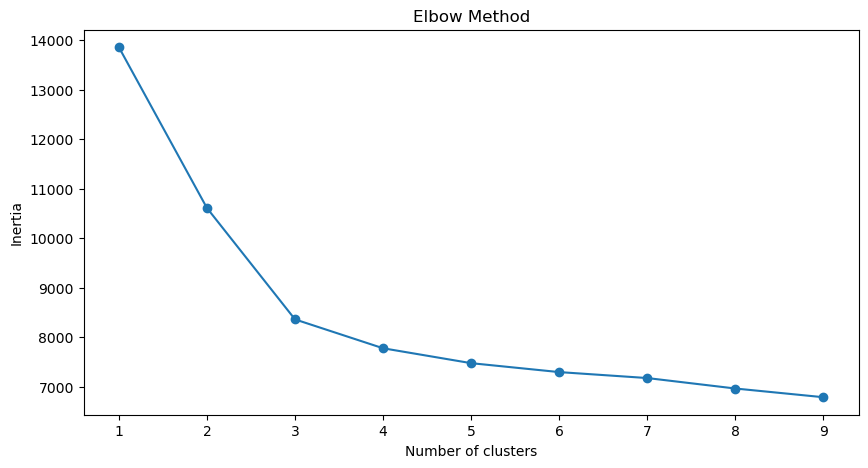

In [16]:
# Import kmeans from sklearn
from sklearn.cluster import KMeans

inertia = []

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(features_unlabeled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), inertia, marker = 'o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


This plot demonstrates that the inertia decreases sharply between 1 and 3 clusters, indicating a significant improvement in clustering quality as the number of clusters increases. However, after 3 clusters, the rate of decrease in inertia slows down considerably, suggesting diminishing returns in adding more clusters. This change in slope, often referred to as the "elbow" point, is where adding additional clusters no longer results in a substantial reduction in inertia. Based on this observation, we have determined that the optimal number of clusters for the unlabeled dataset is 3, as it balances simplicity and clustering effectiveness.

## Different clustering methods

### 1. K-Means Clustering




#### What is K-Means?
- K-Means is an unsupervised learning algorithm that clusters data points into a predefined number of clusters, \( k \).
- The main goal is to minimize the "within-cluster variance". In other words: you want the cluster to be as compact as possible. 

#### How it Works

1. **Initialization**  
   - Randomly pick \( k \) data points from your dataset as the initial “cluster centers” (centroids) 

2. **Assignment**  
   - Then assign every data point to the closest centroid based on a chosen distance metric (euclidian or manhatten for example)

3. **Update (Recompute Centroids)**  
   - Calculate the new centroid for each cluster by taking the mean of all the points assigned to that cluster.  
   - This gives the new positions for \( k \) centroids.

4. **Repeat**  
   - Keep repeating this "recompute centroid" process until the centroids don't change as much / you don't see any improvements or till you reach a preset maximum number of iterations. 

#### Distance Metric
- Typically "Euclidean distance" is used for K-Means:
$$
d(\mathbf{x}_i, \mathbf{x}_j) = \sqrt{\sum_{k=1}^n (x_{ik} - x_{jk})^2}
$$
- Other metrics can be used, but Euclidean is by far the most common one that is used in the K-Means algorithm. 

#### Advantages
- It's easy to understand and relatively efficiënt to compute. 
- It usually performs well, when the data is organized in spherical clusters

#### Disadvantages
- Since it's taking the mean to define the centroids it's sensitive to outliers, because they can affect the mean significantly. 
- You need to choose \( k \) in advance, which could lead to issues. 
- Even though it performs well when the data is organized in spherical clusters, it still assumes that the data is this way, so it might perform worse when it's not organized this way. 
- In very high-dimensional data, Euclidean distance becomes less meaningful.


### 2. K-Medoids Clustering




#### What is K-Medoids?
- K-Medoids is a variation of K-Means, but it's more robust to outliers. 
- K-medoids picks an actual data point within each cluster as its center / centroid instead of using the mean of all the datapoints. 

#### How it Works
$$
d(x, y) = |x - y| = \sqrt{\sum_{i=1}^n (x_i - y_i)^2}
$$

Where:  
- \( d \): distance between \( x \) and \( y \)  
- \( x \): cluster center data  
- \( y \): data on the attribute  
- \( i \): every data point  
- \( n \): amount of data  
- \( x_i \): data at the center of the \( i \)-th cluster  
- \( y_i \): data on each \( i \)-th data point

1. **Initialization**  
   - First you randomly select \( k \) data points as the initial medoids. 

2. **Assignment**  
   - Then assign each leftover point to the cluster with the closest medoid using a predefined distance metric. 

3. **Swapping Medoids**  
   - Try swapping the current medoid with another data point in the same cluster to see if it reduces the distance of the cluster. If it changes, keep the new point as the medoid, otherwise revert it to the old medoid. 

4. **Repeat**  
   - Repeat these swap attemts until there's no improvement in the total distance or until a predefined maximum amount of iterations is reached. 

#### Distance Metric
- Manhatten distance is the most common metric that's being used:
  $$
  d(\mathbf{x}_i, \mathbf{x}_j) = \sum_{k=1}^{n} |x_{ik} - x_{jk}|
  $$
- It's also possible to use other distance metrics like Euclidian distance. Since K-medoids uses actual data points it's often more flexible for different distance metrics. 

#### Advantages
- It's more robust to outliers compared to K-means, because actual data points are being used. 
- It's more flexible with other distance metrics. 

#### Disadvantages
- It's less efficiënt than K-means, because it it repeatedly seraches for a better medoid. 
- You must pick \( k \) in advance. 


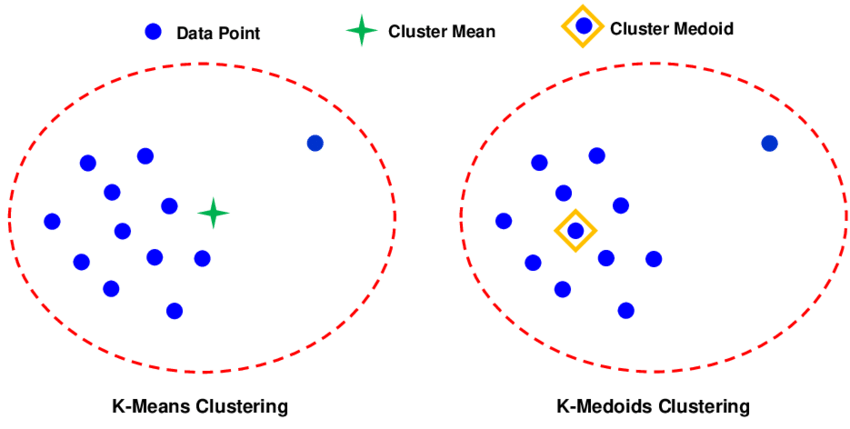

The-graphical-representation-of-the-difference-between-the-k-means-and-k-medoids. (z.d.). Researchgate. https://www.researchgate.net/figure/The-graphical-representation-of-the-difference-between-the-k-means-and-k-medoids_fig1_342871651

Fahrudin, N. F., & Rindiyani, R. (2024). Comparison of K-Medoids and K-Means Algorithms in Segmenting Customers based on RFM Criteria. E3S Web Of Conferences, 484, 02008. https://doi.org/10.1051/e3sconf/202448402008

GeeksforGeeks. (2024a, juni 18). Difference between K means and K medoids Clustering. GeeksforGeeks. https://www.geeksforgeeks.org/k-means-vs-k-medoids-clustering/

What makes the distance measure in k-medoid “better” than k-means? (z.d.). Stack Overflow. https://stackoverflow.com/questions/21619794/what-makes-the-distance-measure-in-k-medoid-better-than-k-means

H, P. N. (2024, 10 januari). Exploring the World of Clustering: K-Means vs. K-Medoids. Medium. https://medium.com/@prasanNH/exploring-the-world-of-clustering-k-means-vs-k-medoids-f648ea738508

### 3. Gaussian Mixture Model (GMM)


#### What is Gaussian Mixture Model (GMM)?

A Gaussian distribution is just a bell curve defined by:

- Mean μ: Where the center of the curve is.
- Variance (σ2): How wide the curve is.

For multiple features (like in our dataset), the Gaussian becomes multi-dimensional, shaped like an ellipsoid.

#### Mixing Gaussians:

GMM assumes the data is made up of multiple Gaussians combined together.

Each Gaussian has:

- A mean (μk): The center of the cluster.
- A covariance (Σ𝑘): The shape and size of the cluster.
- A weight (𝜋𝑘): How much this Gaussian contributes to the overall data.

#### How it finds clusters:

GMM uses a process called Expectation-Maximization (EM) to figure out:
- Where the centers (𝜇𝑘) are.
- How wide or narrow (Σ𝑘) each cluster is.
- How much each Gaussian contributes (𝜋𝑘).

#### Steps of EM:
- E-Step: Calculate probabilities for each data point belonging to each cluster.
- M-Step: Update the cluster centers, sizes, and weights based on those probabilities.
- This repeats until the clusters stop changing.

GMM doesn’t just say, “this point is in Cluster A or B.” Instead, it gives probabilities. For example:
“This song has a 70% chance of being Jazz and 30% chance of being Rock.” This is what we call soft clustering

Cluster using Gaussian mixture model. (n.d.). https://nl.mathworks.com/help/stats/clustering-using-gaussian-mixture-models.html

Jordan, J. (2017, October 18). Soft clustering with Gaussian mixed models (EM). Jeremy Jordan. https://www.jeremyjordan.me/gaussian-mixed-models/

### Which clustering method will we be using and why?

### K-means

- Simple to understand and fast to compute.
- It was not possible for either of us to import K-medoids.
- We have handled the way of using K-Means in class. 


### Mathematical Explanation KMeans Clustering including example

# K-Means Clustering: Mathematical Explanation

## Problem Setup

Assume we have a dataset of m data points, where each data point is represented as a vector in an n-dimensional space:  
**x(i) ∈ ℝⁿ**, for **i = 1, 2, ..., m**.  

The objective is to divide these m points into K clusters while minimizing the within-cluster sum of squares.

## Objective Function

We define K centroids:  
**μ₁, μ₂, ..., μₖ ∈ ℝⁿ**.

For each data point x(i), we define a cluster assignment **rᵢₖ** as:

**rᵢₖ =**  
- 1 if the data point **x(i)** is assigned to cluster `k`,  
- 0 otherwise.

$$
r_{i,k} = 
\begin{cases}
1 & \text{if data point } \mathbf{x}^{(i)} \text{ is assigned to cluster } k, \\
0 & \text{otherwise}.
\end{cases}
$$

The main objective is to find both the cluster assignments rᵢₖ and the centroids μₖ that minimize the within-cluster sum of squares (so the sum of squares from all datapoints in a cluster to the centroid):

$$
J(\{\boldsymbol{\mu}_k\}, \{r_{i,k}\})
= \sum_{i=1}^m \sum_{k=1}^K r_{i,k} \, \|\mathbf{x}^{(i)} - \boldsymbol{\mu}_k\|^2.
$$

Here,  || · || represents the Euclidean norm which measures the distance between a data point and the cluster centroid.

## Algorithmic Steps

### 1) Initialization
First you randomly pick a certain amount of x⁽ⁱ⁾ points from the dataset to serve as the centroids. 

### 2) Assignment Step
After this assign all the leftover x⁽ⁱ⁾ datapoints to the centroids closest using a predefined distance metric. 

$$
r_{i,k} := 
\begin{cases}
1 & \text{if } k = \arg\min_{j} \|\mathbf{x}^{(i)} - \boldsymbol{\mu}_j\|^2,\\
0 & \text{otherwise}.
\end{cases}
$$

### 3) Update Step
Then recalculate each centroid as the mean of the points assigned to each specific cluster:


$$
\boldsymbol{\mu}_k := 
\frac{\sum_{i=1}^m r_{i,k}\,\mathbf{x}^{(i)}}
     {\sum_{i=1}^m r_{i,k}}.
$$

### 4) Repeat
Keep repeating step 2 and 3 until the clusters don't change anymore or when a maximum number of iterations is reached. 

## Distance Metric
The euclidean distance is used by default, which is calculated the following:

$$
d(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}) = 
\sqrt{\sum_{\ell=1}^n \bigl(x^{(i)}_\ell - x^{(j)}_\ell\bigr)^2}.
$$

Sharma, N. (2024, 15 april). K-Means Clustering explained. neptune.ai. https://neptune.ai/blog/k-means-clustering

ChatGPT - New chat. (z.d.). ChatGPT. https://chatgpt.com/share/6790cd05-83d0-800b-a2db-457eb142a42a


## Applying clustering to unlabeled dataset

We will apply the KMeans clustering method to the unlabeled dataset and incorporate the cluster IDs into it.

In [17]:
#KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=0)

kmeans.fit_predict(features_unlabeled)

audio_features_unlabeled['cluster'] = kmeans.labels_

audio_features_unlabeled['cluster'].value_counts()


cluster
1    40
0    36
2    29
Name: count, dtype: int64

## Comparing the features of the clusters with the labeled data

In this section, we will create a function to compare two distinct audio features using a scatterplot across various music genres. This will assist in identifying patterns and relationships within the data, with a particular focus on how the labeled genres align with any potential unlabeled clusters.

In [ ]:
def plot_feature_combinations(feature_combination, genres, audio_features_labeled, audio_features_unlabeled):
    """
    Plots a 5x2 grid of scatter plots for a single feature combination across multiple genres.

    Parameters:
        feature_combination (tuple): A tuple containing two feature names (x_feature, y_feature).
        genres (list): A list of genres to be plotted.
        audio_features_labeled (DataFrame): Labeled data containing audio features and genre information.
        audio_features_unlabeled (DataFrame): Unlabeled data containing audio features and cluster information.
    """

    x_feature, y_feature = feature_combination

    # Defining the number of columns and calculate the required rows
    cols = 5
    rows = 2

    # Color palettes
    cluster_palette = sns.color_palette("pastel", as_cmap=False)
    genre_palette = sns.color_palette("dark", n_colors=len(genres))  
    fig, axes = plt.subplots(rows, cols, figsize=(25, 10), sharex=False, sharey=True)

    # Flatten axes
    axes = axes.flatten()

    for i, genre in enumerate(genres):
        if i >= rows * cols:
            break
        ax = axes[i]

        filtered_labeled = audio_features_labeled[audio_features_labeled['genre'] == genre]

        # Scatterplot for clusters 
        sns.scatterplot(
            x=audio_features_unlabeled[x_feature],
            y=audio_features_unlabeled[y_feature],
            hue=audio_features_unlabeled['cluster'],
            palette=cluster_palette,
            alpha=0.5,
            ax=ax
        )

        # Scatterplot for the current genre
        sns.scatterplot(
            x=filtered_labeled[x_feature],
            y=filtered_labeled[y_feature],
            color=genre_palette[genres.index(genre)],
            label=genre,
            alpha=0.8,
            ax=ax
        )

        ax.set_title(f"Genre: {genre}")
        ax.set_xlabel(x_feature.replace('_', ' ').title())
        ax.set_ylabel(y_feature.replace('_', ' ').title())

    for i in range(len(genres), rows * cols):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# ChatGPT - 2D Scatterplot with Hue. (z.d.). ChatGPT. https://chatgpt.com/share/67c82657-626c-8010-892e-dea88316bace
# Zelf formule aangepast op basis van bovenstaande bron

In [19]:
# List of genres to make plots with
genres = ['jazz', 'reggae', 'rock', 'disco', 'classical', 'hiphop', 'country', 'metal', 'blues', 'pop']

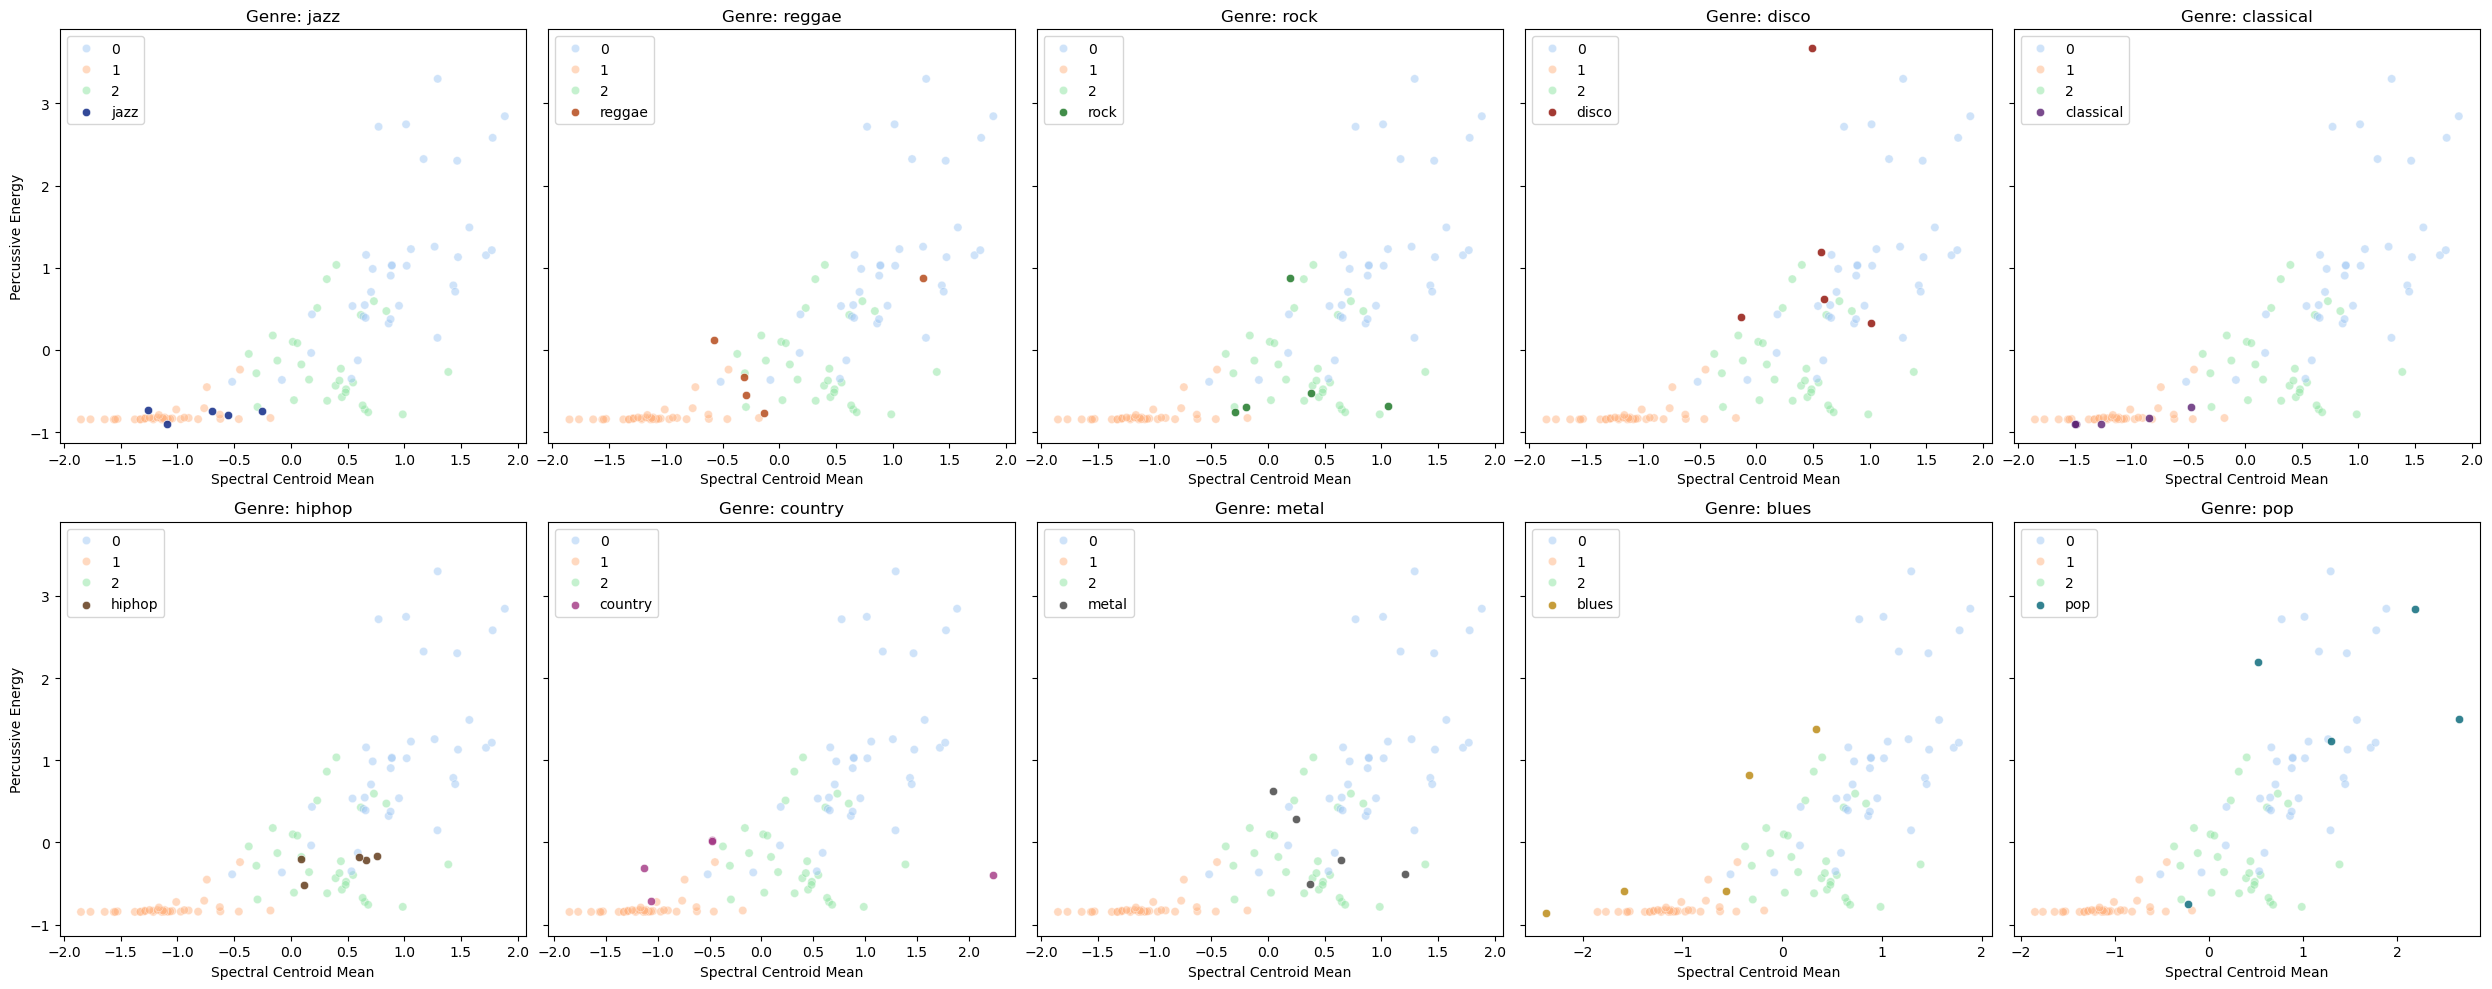

In [20]:
# Spectal_centroid_mean and percussive_energy plotted for each genre

plot_feature_combinations(
    ('spectral_centroid_mean', 'percussive_energy'),
    genres,
    audio_features_labeled,
    audio_features_unlabeled
)


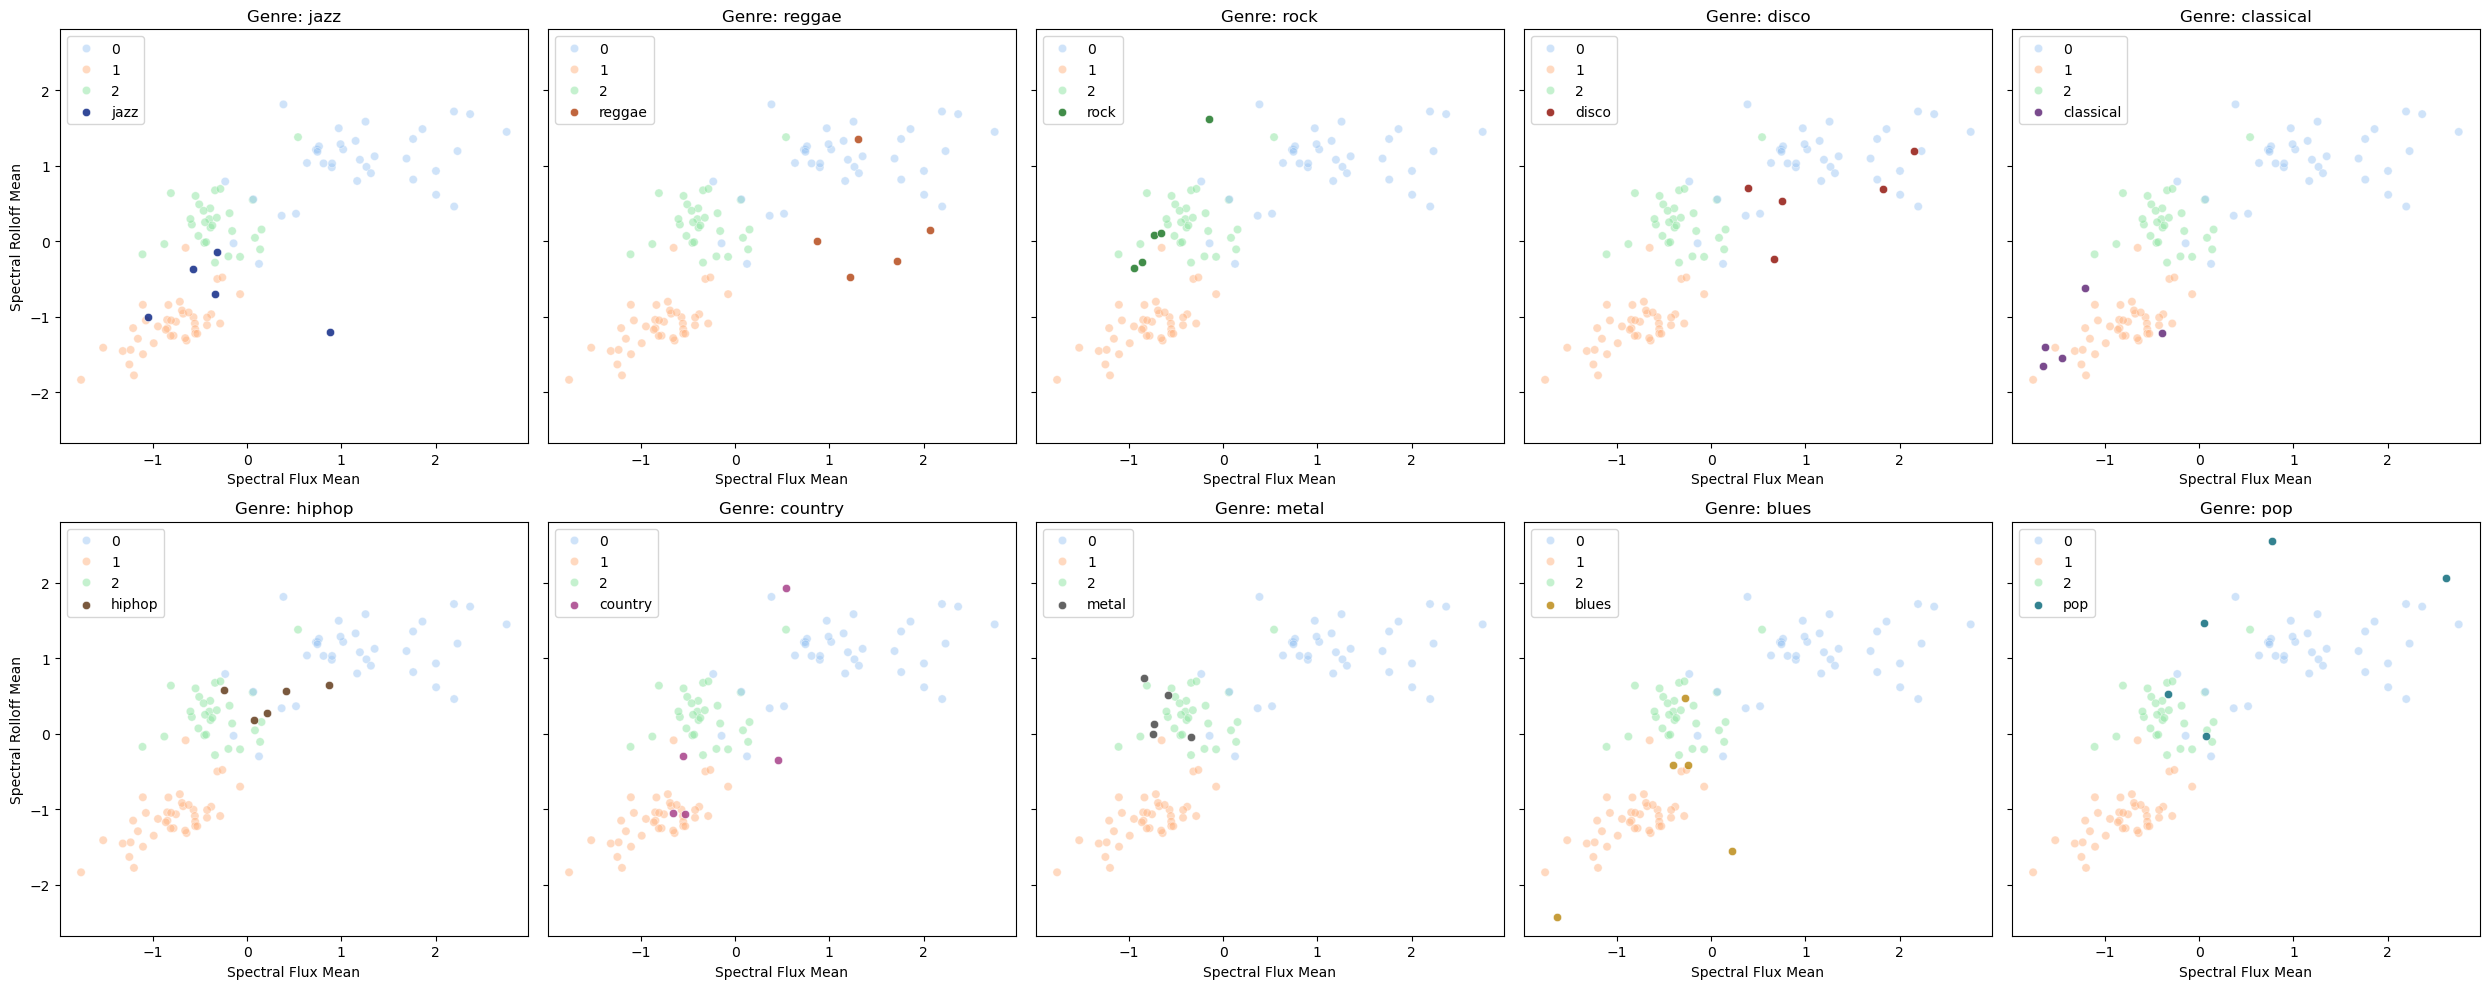

In [21]:
# Spectal_flux_mean and spectral_rolloff_mean plotted for each genre

plot_feature_combinations(
    ('spectral_flux_mean', 'spectral_rolloff_mean'),
    genres,
    audio_features_labeled,
    audio_features_unlabeled
)


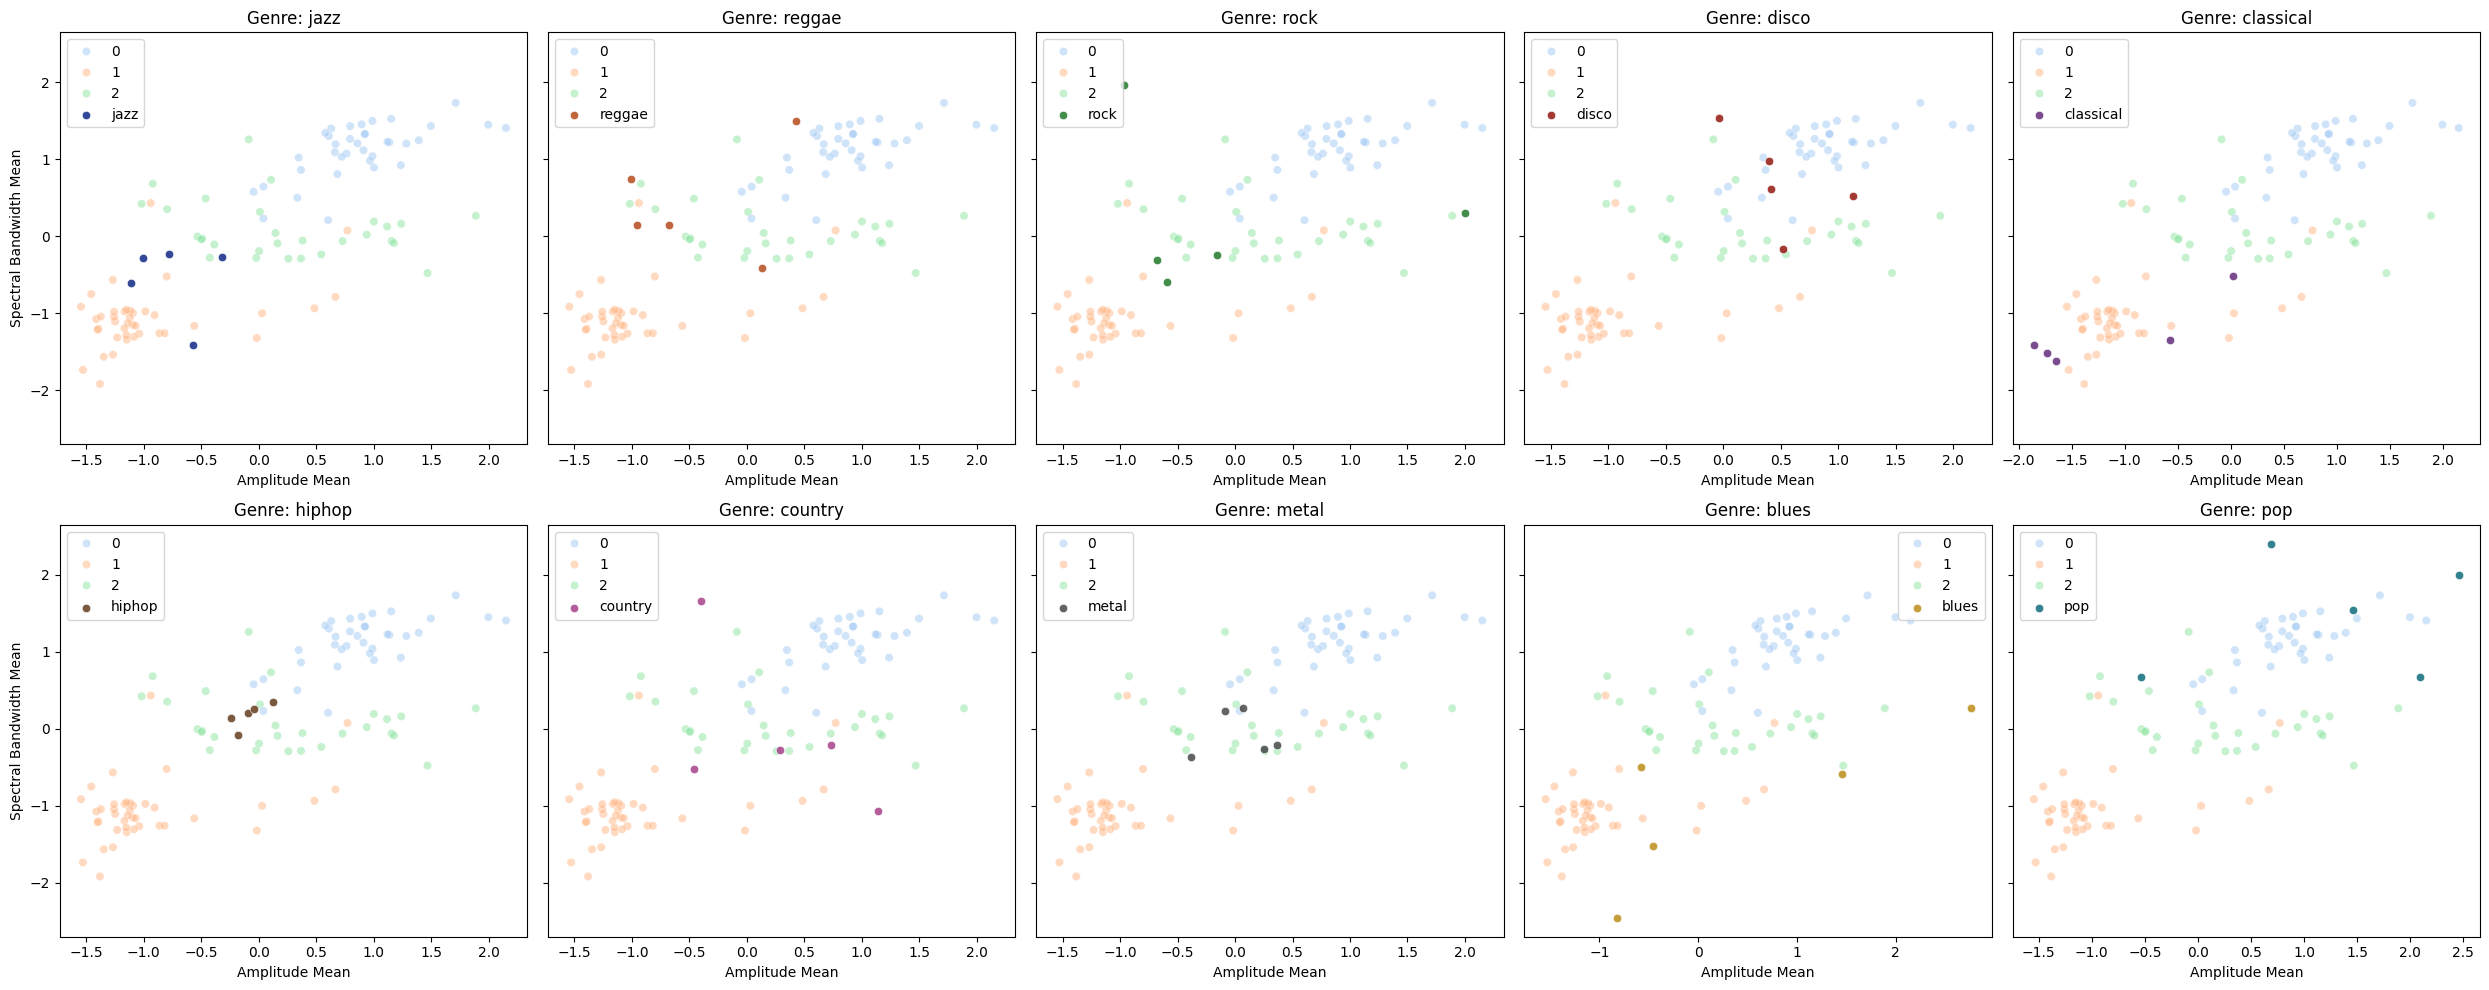

In [ ]:
# amplitude_mean and spectral_bandwidth_mean plotted for each genre

plot_feature_combinations(
    ('amplitude_mean', 'spectral_bandwidth_mean'),
    genres,
    audio_features_labeled,
    audio_features_unlabeled
)

Based on the graphs above, the following genres have been assigned to the three clusters:

**Cluster 0: Pop**  
The assignment for Cluster 0 is clear: it corresponds to the Pop genre. In all scatter plots for the "Pop" genre, the unlabeled data points are consistently located around Cluster 0, which is not the case for any other genre.

**Cluster 1: Classical**  
When analyzing the plots for Cluster 1, both Jazz and Classical genres seem plausible candidates. This is understandable, as these genres share several similarities. However, subplots 2 and 3 confirm that Cluster 1 corresponds to Classical music, as the unlabeled data points align more closely with Cluster 1 in these plots.

**Cluster 2: Metal**  
For Cluster 2, two potential genres were considered: Rock and Metal. Similar to Jazz and Classical, these genres are relatively similar in characteristics. However, in the plots, the data points for Metal align slightly better with Cluster 2, leading to its assignment.



Here we will change the cluster numbers to the genre names

In [ ]:
audio_features_unlabeled_kaggle = audio_features_unlabeled.copy()

In [ ]:
def map_clusters_to_genres(df, cluster_genre_map):
    """
    Maps cluster labels to genre names in the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing the cluster labels.
    cluster_genre_map (dict): Dictionary mapping cluster labels to genre names.

    Returns:
    pd.DataFrame: DataFrame with updated genre names.
    """
    
    # Changing the cluster labels to the genre names
    df['cluster'] = df['cluster'].map(cluster_genre_map)

    # Changing the file_name column to filename
    df.rename(columns={'file_name': 'filename'}, inplace=True)

    # Changing the cluster column to genre
    df.rename(columns={'cluster': 'genre'}, inplace=True)
    df = df[['filename', 'genre']]

    return df

cluster_genre_map = {0: 'pop', 1: 'classical', 2: 'metal'}
audio_features_unlabeled_kaggle = map_clusters_to_genres(audio_features_unlabeled_kaggle, cluster_genre_map)
display(audio_features_unlabeled_kaggle.head())

,filename,genre
0,m00003.wav,metal
1,m00012.wav,metal
2,m00013.wav,classical
3,m00043.wav,metal
4,m00044.wav,classical


#### Kaggle Score KMeans

In [ ]:
# Save the Kaggle submission file

audio_features_unlabeled_kaggle.to_csv('audio_features_unlabeled_kaggle.csv', index=False)



## Dimensionality reduction

### Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is an unsupervised learning technique used to analyze relationships between variables. It transforms correlated variables into uncorrelated ones through an orthogonal transformation. The main purpose of PCA is to reduce dataset dimensions while preserving important patterns and relationships.

Math formula:

​Step 1: standardize

Ensure that all the features are on the same scale. The reason you do this is to make sure certain features don't dominate other features. 

Z= (X−μ) / σ

By standardizing the dataset you make sure that each variable has a mean of 0 and a standard deviation of 1. 

Step 2: Find realationships. 

After that you calculate how features vary together using the covariance matrix. This covariance matrix measures the strength of the shared variability between two or more variables, showing how then can change relative to eachother. This matrix is calculated with the following formula:

$$
\text{cov}(x_1, x_2) = \frac{1}{n-1} \sum_{i=1}^{n} (x_{1i} - \bar{x}_1)(x_{2i} - \bar{x}_2)
$$

The covariance can be positive, negative or zero:
- It's positive when the x2 also increases when the x1 increases
- It's negative when the x2 decreases when the x1 increases
- It's zero when there's no direct relationship between the variables. 

Step 3: Find the Principal Components.

Then you find the principal components. These principal components are the directions in the graph where the data spreads out the most. THis means the direction with the most variance. These directions are caculated by using the eigenvalues and eigenvectors. Eigenvectors are the directions and the eigenvalues are there corresponding variance.

For a square matrix A, an eigenvector X (a non-zero vector) and its corresponding eigenvalue λ (a scalar) satisfy the equation:

AX = λX

Step 4: Choosing amount of principal components and transforming the data. 

When making the principal components you visualize a cumulative explained variance plot to see how much variance the principal components capture. Usually you keep the first 2 or 3 components or you base it on the amount of variance they capture (minimum around 95%).

Then you transform the data on these chosen directions to get a simplified and lower dimension.

GeeksforGeeks. (2024, September 10). Principal Component Analysis(PCA). GeeksforGeeks. https://www.geeksforgeeks.org/principal-component-analysis-pca/

### Applying PCA and k means clustering

#### Finding the amount of PCA features

In [ ]:
# Making a dataset with just the features in the labeled data, so pca can be applied to it
features_labeled = audio_features_labeled.drop(['file_name', 'genre'], axis=1)
labels_labeled = audio_features_labeled[['file_name', 'genre']]

In [ ]:
# Defining and fitting the PCA model

pca = PCA()

pca.fit(features_unlabeled)



PCA()

Text(0.5, 1.0, 'Explained Variance Ratio by Principal Component')

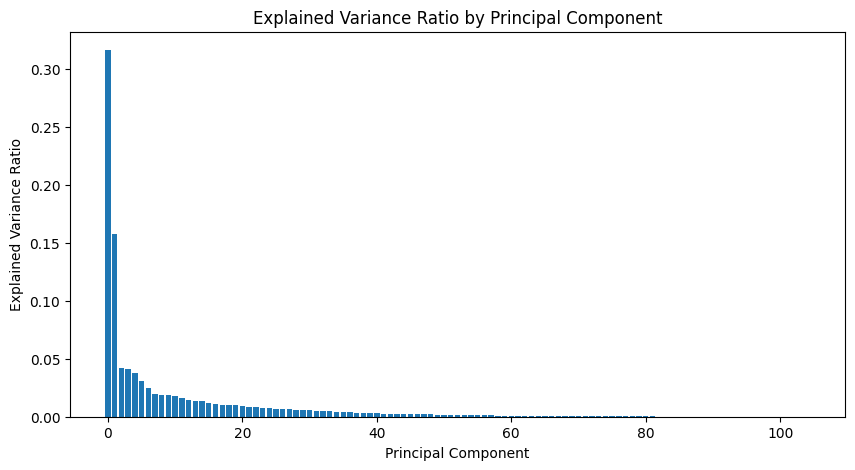

In [ ]:
# Scree plot to find optimal number of components

plt.figure(figsize=(10, 5))

plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)

plt.xlabel('Principal Component')

plt.ylabel('Explained Variance Ratio')

plt.title('Explained Variance Ratio by Principal Component')


Looking at this elbow plot, we decided to use the first three PCA features. This point on the graph represents the threshold where adding more PCA components does not significantly increase the explained variance (or information). In other words, beyond this point, additional components contribute minimally to the overall understanding of the dataset. By selecting the first three PCA features, we strike a balance between dimensionality reduction and retaining as much meaningful variance as possible, ensuring that the model remains both efficient and effective.

#### Applying PCA on the unlabeled data

We create a new DataFrame with only the first three PCA components to reapply k-means clustering and assess whether the results improve compared to the original audio features dataset.

In [ ]:
pca = PCA(n_components=3)

pca_features = pca.fit_transform(features_unlabeled)

pca_df = pd.DataFrame(pca_features, columns=[f'PC{i+1}' for i in range(3)])

display(pca_df)



,PC1,PC2,PC3
0,0.682419,6.630192,1.284663
1,1.068867,7.976751,0.623577
2,-4.931586,0.745766,2.033457
3,1.091750,6.405317,-0.178612
4,-6.504448,-4.924103,-2.962237
...,...,...,...
100,-5.186937,-0.901364,-0.250676
101,5.965757,0.249312,-0.495637
102,13.236768,-5.097595,0.228176
103,-9.743318,-2.307249,-5.969722


Now, we will apply k-means clustering to the dataframe containing PCA features.

In [ ]:
kmeans_pca = KMeans(n_clusters=3, random_state=42)  # Set n_clusters to 3 as per the requirement
kmeans_pca.fit(pca_df)

# Add the cluster labels to the DataFrame
pca_df['cluster'] = kmeans_pca.labels_
display(pca_df.head())

,PC1,PC2,PC3,cluster
0,0.682419,6.630192,1.284663,2
1,1.068867,7.976751,0.623577,2
2,-4.931586,0.745766,2.033457,1
3,1.091750,6.405317,-0.178612,2
4,-6.504448,-4.924103,-2.962237,1


In [ ]:
# Checking if the amount of each cluster has changed
display(pca_df['cluster'].value_counts())


cluster
1    40
0    36
2    29
Name: count, dtype: int64

#### Applying PCA on the labeled dataset

In [ ]:
# Separating file_name and genre
file_name_and_genre = audio_features_labeled[['file_name', 'genre']]

# Applying PCA to the labeled data
pca_labeled = PCA(n_components=3)
pca_features = pca_labeled.fit_transform(features_labeled)

pca_df_labeled = pd.DataFrame(pca_features, columns=['PC1', 'PC2', 'PC3'])

# Concatenating the file_name, genre, and PCA features
audio_features_labeled_pca = pd.concat([file_name_and_genre, pca_df_labeled], axis=1)

display(audio_features_labeled_pca.head())

,file_name,genre,PC1,PC2,PC3
0,m00002.wav,jazz,-8.898670,5.409942,0.626360
1,m00039.wav,reggae,4.051451,6.559253,4.574052
2,m00041.wav,pop,3.386466,0.637519,-2.114473
3,m00072.wav,disco,3.739558,-1.665523,-1.282564
4,m00096.wav,disco,9.906504,2.149019,6.929795


## Non-negative Matrix Factorization 



Non-Negative Matrix Factorization (NMF) is a method for decomposing a large dataset into smaller, meaningful components while keeping all values non-negative. This makes it easier to extract useful features, analyze, and process the data. This method assumes that data consists of meaningful parts that add up to form the whole. 

It decomposes a matrix into two smaller matrixes like the formula shows below:

$$
A_{m \times n} = W_{m \times k} H_{k \times n}
$$

Where:
- A = the original matrix input, which is a linear combination between 'W' and 'H'.
- W =  the feature matrix, which are the basis components
- H = the coefficient matrix, which are the weights that are associated with 'W'
- k = the rank, which is the dimensionality of the reduced representation.

NMF decomposes a data matrix 'A' into two smaller matrixes 'W' and 'H'. This is done by using an iterative optimization process:

First you start with random non-negative values for the smaller matrixes 'W' and 'H'. 

After that you modifiy 'W' and 'H' to minimize the difference between the original matrix 'A' and the two new (smaller) matrixes 'W' x 'W'. 

You keep iterating until the recontruction error doesn't change anymore or a predefined number of iterations is used. 


Source:
GeeksforGeeks. (2023, March 2). NonNegative Matrix Factorization. GeeksforGeeks. https://www.geeksforgeeks.org/non-negative-matrix-factorization/

### Applying NMF and k means clustering


#### Normalizing the data and finding the amount of NMF features

To apply NMF, we must ensure that the dataframe (both labeled and unlabeled) contains no negative values.

In [ ]:
# Scale the unlabeled features to have a range of 0 to 1
scaler_unlabeled = MinMaxScaler(feature_range=(0, 1))
features_positive_unlabeled = scaler_unlabeled.fit_transform(features_unlabeled)

features_positive_df_unlabeled = pd.DataFrame(features_positive_unlabeled, columns=features_unlabeled.columns)

In [ ]:
# Scale the labeled features to have a range of 0 to 1
scaler_labeled = MinMaxScaler(feature_range=(0, 1))
features_positive_labeled = scaler_labeled.fit_transform(features_labeled)

features_positive_df_labeled = pd.DataFrame(features_positive_labeled, columns=features_labeled.columns)

In [ ]:
# After scaling, you can merge them back with the file_name_genre
audio_features_labeled_normalised = pd.DataFrame(features_positive_df_labeled, columns=features_labeled.columns)
audio_features_labeled_normalised = pd.concat([labels_labeled, audio_features_labeled_normalised], axis=1)

In [ ]:
display(audio_features_labeled_normalised.head())

,file_name,genre,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,mfcc_mean_11,mfcc_mean_12,mfcc_var_0,mfcc_var_1,mfcc_var_2,mfcc_var_3,mfcc_var_4,mfcc_var_5,mfcc_var_6,mfcc_var_7,mfcc_var_8,mfcc_var_9,mfcc_var_10,mfcc_var_11,mfcc_var_12,mfcc_delta_mean_0,mfcc_delta_mean_1,mfcc_delta_mean_2,mfcc_delta_mean_3,mfcc_delta_mean_4,mfcc_delta_mean_5,mfcc_delta_mean_6,mfcc_delta_mean_7,mfcc_delta_mean_8,mfcc_delta_mean_9,mfcc_delta_mean_10,mfcc_delta_mean_11,mfcc_delta_mean_12,mfcc_delta_var_0,mfcc_delta_var_1,mfcc_delta_var_2,mfcc_delta_var_3,mfcc_delta_var_4,mfcc_delta_var_5,mfcc_delta_var_6,mfcc_delta_var_7,mfcc_delta_var_8,mfcc_delta_var_9,mfcc_delta_var_10,mfcc_delta_var_11,mfcc_delta_var_12,spectral_centroid_mean,spectral_centroid_var,spectral_rolloff_mean,spectral_rolloff_var,spectral_flux_mean,spectral_flux_var,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_contrast_var_0,spectral_contrast_var_1,spectral_contrast_var_2,spectral_contrast_var_3,spectral_contrast_var_4,spectral_contrast_var_5,spectral_contrast_var_6,envelope_mean,envelope_var,spectral_bandwidth_mean,spectral_bandwidth_var,rms_mean,rms_var,energy,amplitude_mean,amplitude_var,dynamic_range,tempo_0,beat_strength_mean,beat_strength_var,ibi_var,ibi_mean,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,chroma_var_0,chroma_var_1,chroma_var_2,chroma_var_3,chroma_var_4,chroma_var_5,chroma_var_6,chroma_var_7,chroma_var_8,chroma_var_9,chroma_var_10,chroma_var_11,tonnetz_mean_0,tonnetz_mean_1,tonnetz_mean_2,tonnetz_mean_3,tonnetz_mean_4,tonnetz_mean_5,tonnetz_var_0,tonnetz_var_1,tonnetz_var_2,tonnetz_var_3,tonnetz_var_4,tonnetz_var_5,hpr,harmonic_energy,percussive_energy,zcr_mean,zcr_var,onset_acf_mean,onset_acf_var,skewness,kurtosis
0,m00002.wav,jazz,0.309351,0.581100,0.616977,0.397273,0.371962,0.570389,0.311758,0.534912,0.437353,0.691687,0.536545,0.430486,0.545388,0.131460,0.142980,0.164684,0.143751,0.110759,0.106840,0.223371,0.161137,0.144999,0.275856,0.460909,0.753108,0.516714,0.512898,0.616869,0.731048,0.730973,0.498859,0.566631,0.728114,0.493737,0.605910,0.190198,0.411237,0.399562,0.644065,0.119389,0.067901,0.085671,0.095629,0.190214,0.098236,0.091814,0.084475,0.082594,0.096393,0.176831,0.264124,0.197163,0.253135,0.077178,0.284172,0.259935,0.141721,0.089211,0.377724,0.833410,0.845333,0.962039,0.785406,0.475976,0.660266,0.479451,0.914514,1.000000,0.727687,0.565110,0.232350,0.075603,0.162114,0.039978,0.380419,0.199967,0.156868,0.046512,0.040307,0.162114,0.039978,0.271496,0.560000,0.141721,0.089211,0.087508,0.196679,0.234483,0.186795,0.419171,0.346098,0.176760,0.244025,0.206005,0.280653,0.477073,0.276615,0.127666,0.024379,0.365919,0.478857,1.000000,0.657164,0.445808,0.653411,0.463192,0.714366,1.000000,0.584685,0.306457,0.442317,0.336480,0.629475,0.691604,0.567687,0.000000,0.373538,1.000000,0.559548,0.556507,0.915129,0.627052,0.543668,0.061798,0.065219,0.002399,0.154860,0.031272,0.082674,0.011358,0.431426,0.156355
1,m00039.wav,reggae,0.599664,0.569316,0.467947,0.603857,0.496860,0.822671,0.246047,0.543407,0.348601,0.492869,0.419578,0.743897,0.409154,0.668162,0.669997,0.279548,0.618352,0.408986,0.445773,1.000000,0.740307,1.000000,0.794247,0.411758,0.398655,0.356087,0.639232,0.437195,0.430574,0.580447,0.466595,0.528154,0.532983,0.294455,0.400652,0.190062,0.694439,0.879552,0.356354,0.745590,0.474555,0.306361,0.581909,0.690913,0.334490,1.000000,0.611246,1.000000,0.796521,0.652660,0.484725,0.703268,0.356382,0.304674,0.392497,0.420132,0.671480,0.680785,0.396046,0.483078,0.507515,0.429635,0.531756,0.357609,0.782430,0.693550,0.370787,0.859073,0.467442,0.624997,0.495124,0.378002,0.430676,0.227563,0.421157,0.331442,0.436957,0.183018,0.229096,0.430

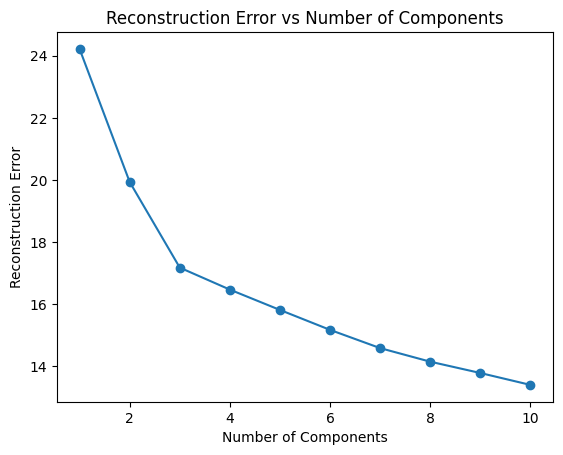

In [ ]:
errors = []
for n in range(1, 11):  
    nmf = NMF(n_components=n, random_state=42)
    W = nmf.fit_transform(features_positive_df_unlabeled)
    H = nmf.components_
    reconstruction_error = np.linalg.norm(features_positive_df_unlabeled - np.dot(W, H), 'fro')
    errors.append(reconstruction_error)

plt.plot(range(1, 11), errors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs Number of Components')
plt.show()

The plot shows that we need three NMF components, which match the number of clusters in the unlabeled dataset. This is based on the 'elbow point' in the graph, where adding more NMF components doesn’t significantly improve the explained information.

#### Applying NMF to the unlabeled dataset


In [ ]:
# Initialize NMF for the unlabeled data
n_components = 3  
nmf = NMF(n_components=n_components, random_state=42)

# Fit and transform the data
W_unlabeled = nmf.fit_transform(features_positive_df_unlabeled) 
H_unlabeled = nmf.components_      

In [ ]:
nmf_df= pd.DataFrame(W_unlabeled)

display(nmf_df.head())

,0,1,2
0,0.110388,0.065456,0.777652
1,0.107340,0.012059,0.869604
2,0.026681,0.415346,0.457281
3,0.128388,0.047545,0.757936
4,0.087818,0.610413,0.024187


In [ ]:
kmeans_nmf = KMeans(n_clusters=3, random_state=42)  
kmeans_nmf.fit(nmf_df)

# Add the cluster labels to the DataFrame
nmf_df['cluster'] = kmeans_nmf.labels_
display(nmf_df.head())

,0,1,2,cluster
0,0.110388,0.065456,0.777652,1
1,0.107340,0.012059,0.869604,1
2,0.026681,0.415346,0.457281,2
3,0.128388,0.047545,0.757936,1
4,0.087818,0.610413,0.024187,2


In [ ]:
# Checking if the amount of each cluster has changed
display(nmf_df['cluster'].value_counts())


cluster
2    40
0    39
1    26
Name: count, dtype: int64

In [ ]:
# Renaming the NMF columns
nmf_df.rename(columns={col: f"NMF{col}" for col in nmf_df.columns[:3]}, inplace=True)

In [ ]:
display(nmf_df.head())

,NMF0,NMF1,NMF2,cluster
0,0.110388,0.065456,0.777652,1
1,0.107340,0.012059,0.869604,1
2,0.026681,0.415346,0.457281,2
3,0.128388,0.047545,0.757936,1
4,0.087818,0.610413,0.024187,2


#### Applying NMF to the labeled dataset


In [ ]:
file_name_and_genre = audio_features_labeled_normalised[['file_name', 'genre']]
features_labeled_normalised = audio_features_labeled_normalised.drop(['file_name', 'genre'], axis=1)

# Applying NMF to the labeled data with n_components=3 (you can adjust the number of components as needed)
nmf = NMF(n_components=3, random_state=42)
nmf_features = nmf.fit_transform(features_labeled_normalised)

nmf_df_labeled = pd.DataFrame(nmf_features, columns=['NMF0', 'NMF1', 'NMF2'])

# Concatenating 'file_name', 'genre', and NMF features
audio_features_labeled_nmf = pd.concat([file_name_and_genre, nmf_df_labeled], axis=1)

display(audio_features_labeled_nmf.head())

,file_name,genre,NMF0,NMF1,NMF2
0,m00002.wav,jazz,0.124806,0.845278,0.069604
1,m00039.wav,reggae,0.112719,0.353592,0.873152
2,m00041.wav,pop,0.170290,0.139543,0.708158
3,m00072.wav,disco,0.300167,0.054709,0.656440
4,m00096.wav,disco,0.331365,0.010296,0.986527


## Comparing the features of the clusters with the labeled data a second time to see if it has improved

We will now create the same plots to align the clusters with the genres, allowing us to observe any changes after reducing the dimensionality of the data. This analysis will be conducted for both PCA and NMF.

In [ ]:
def plot_feature_combinations_pca(feature_combination, genres, pca_df, audio_features_labeled_pca):
    """
    Plots a 5x2 grid of scatter plots for a single feature combination across multiple genres in the PCA-reduced data.

    Parameters:
        feature_combination (tuple): A tuple containing two feature names (x_feature, y_feature).
        genres (list): A list of genres to be plotted.
        pca_df (DataFrame): DataFrame containing PCA-reduced features and cluster information.
        audio_features_labeled_pca (DataFrame): DataFrame containing labeled PCA features and genre information.
    """
    # Unpack the feature combination
    x_feature, y_feature = feature_combination

    # Defining the number of columns and calculate the required rows
    cols = 5
    rows = 2

    # Color palettes 
    cluster_palette = sns.color_palette("pastel", as_cmap=False)
    genre_palette = sns.color_palette("dark", n_colors=len(genres))

    # Setting up the subplots
    fig, axes = plt.subplots(rows, cols, figsize=(25, 10), sharex=False, sharey=True)

    # Flatten axes 
    axes = axes.flatten()

    # Plot for each individual genre
    for i, genre in enumerate(genres):
        if i >= rows * cols:
            break  # Stop if we exceed the available subplot slots

        # Current subplot
        ax = axes[i]

        # Filter labeled PCA data for the current genre (audio_features_labeled_pca)
        filtered_labeled_pca = audio_features_labeled_pca[audio_features_labeled_pca['genre'] == genre]

        # Scatterplot for clusters 
        sns.scatterplot(
            x=pca_df[x_feature],
            y=pca_df[y_feature],
            hue=pca_df['cluster'],
            palette=cluster_palette,
            alpha=0.5,
            ax=ax
        )

        # Scatterplot for the current genre 
        sns.scatterplot(
            x=filtered_labeled_pca[x_feature],
            y=filtered_labeled_pca[y_feature],
            color=genre_palette[genres.index(genre)],
            label=genre,
            alpha=0.8,
            ax=ax
        )

        ax.set_title(f"Genre: {genre}")
        ax.set_xlabel(x_feature.replace('_', ' ').title())
        ax.set_ylabel(y_feature.replace('_', ' ').title())


    for i in range(len(genres), rows * cols):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# ChatGPT - 2D Scatterplot with Hue. (z.d.). ChatGPT. https://chatgpt.com/share/67c82657-626c-8010-892e-dea88316bace
# Zelf formule aangepast op basis van bovenstaande bron

In [ ]:
def plot_feature_combinations_nmf(feature_combination, genres, nmf_df, audio_features_labeled):
    """
    Plots a 5x2 grid of scatter plots for a single feature combination across multiple genres in the NMF-reduced data.

    Parameters:
        feature_combination (tuple): A tuple containing two feature names (x_feature, y_feature).
        genres (list): A list of genres to be plotted.
        nmf_df (DataFrame): DataFrame containing NMF-reduced features and cluster information.
        audio_features_labeled (DataFrame): Labeled data containing audio features and genre information.
    """
    # Unpack the feature combination
    x_feature, y_feature = feature_combination

    # Defining the number of columns and calculate the required rows
    cols = 5
    rows = 2

    # Color palettes 
    cluster_palette = sns.color_palette("pastel", as_cmap=False) 
    genre_palette = sns.color_palette("dark", n_colors=len(genres))  

    # Setting up the subplots
    fig, axes = plt.subplots(rows, cols, figsize=(25, 10), sharex=False, sharey=True)

    # Flatten axes 
    axes = axes.flatten()

    # Plot for each individual genre
    for i, genre in enumerate(genres):
        if i >= rows * cols:
            break  # Stop if we exceed the available subplot slots

        # Current subplot
        ax = axes[i]

        # Filter labeled data for the current genre
        filtered_labeled = audio_features_labeled[audio_features_labeled['genre'] == genre]

        # Scatterplot for clusters
        sns.scatterplot(
            x=nmf_df[x_feature],
            y=nmf_df[y_feature],
            hue=nmf_df['cluster'],  
            palette=cluster_palette,  
            alpha=0.5,
            ax=ax
        )

        # Scatterplot for the current genre
        sns.scatterplot(
            x=filtered_labeled[x_feature],
            y=filtered_labeled[y_feature],
            color=genre_palette[genres.index(genre)], 
            label=genre,
            alpha=0.8,
            ax=ax
        )

        ax.set_title(f"Genre: {genre}")
        ax.set_xlabel(x_feature.replace('_', ' ').title())
        ax.set_ylabel(y_feature.replace('_', ' ').title())

    for i in range(len(genres), rows * cols):
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# ChatGPT - 2D Scatterplot with Hue. (z.d.). ChatGPT. https://chatgpt.com/share/67c82657-626c-8010-892e-dea88316bace
# Zelf formule aangepast op basis van bovenstaande bron


### PCA vs labeled data

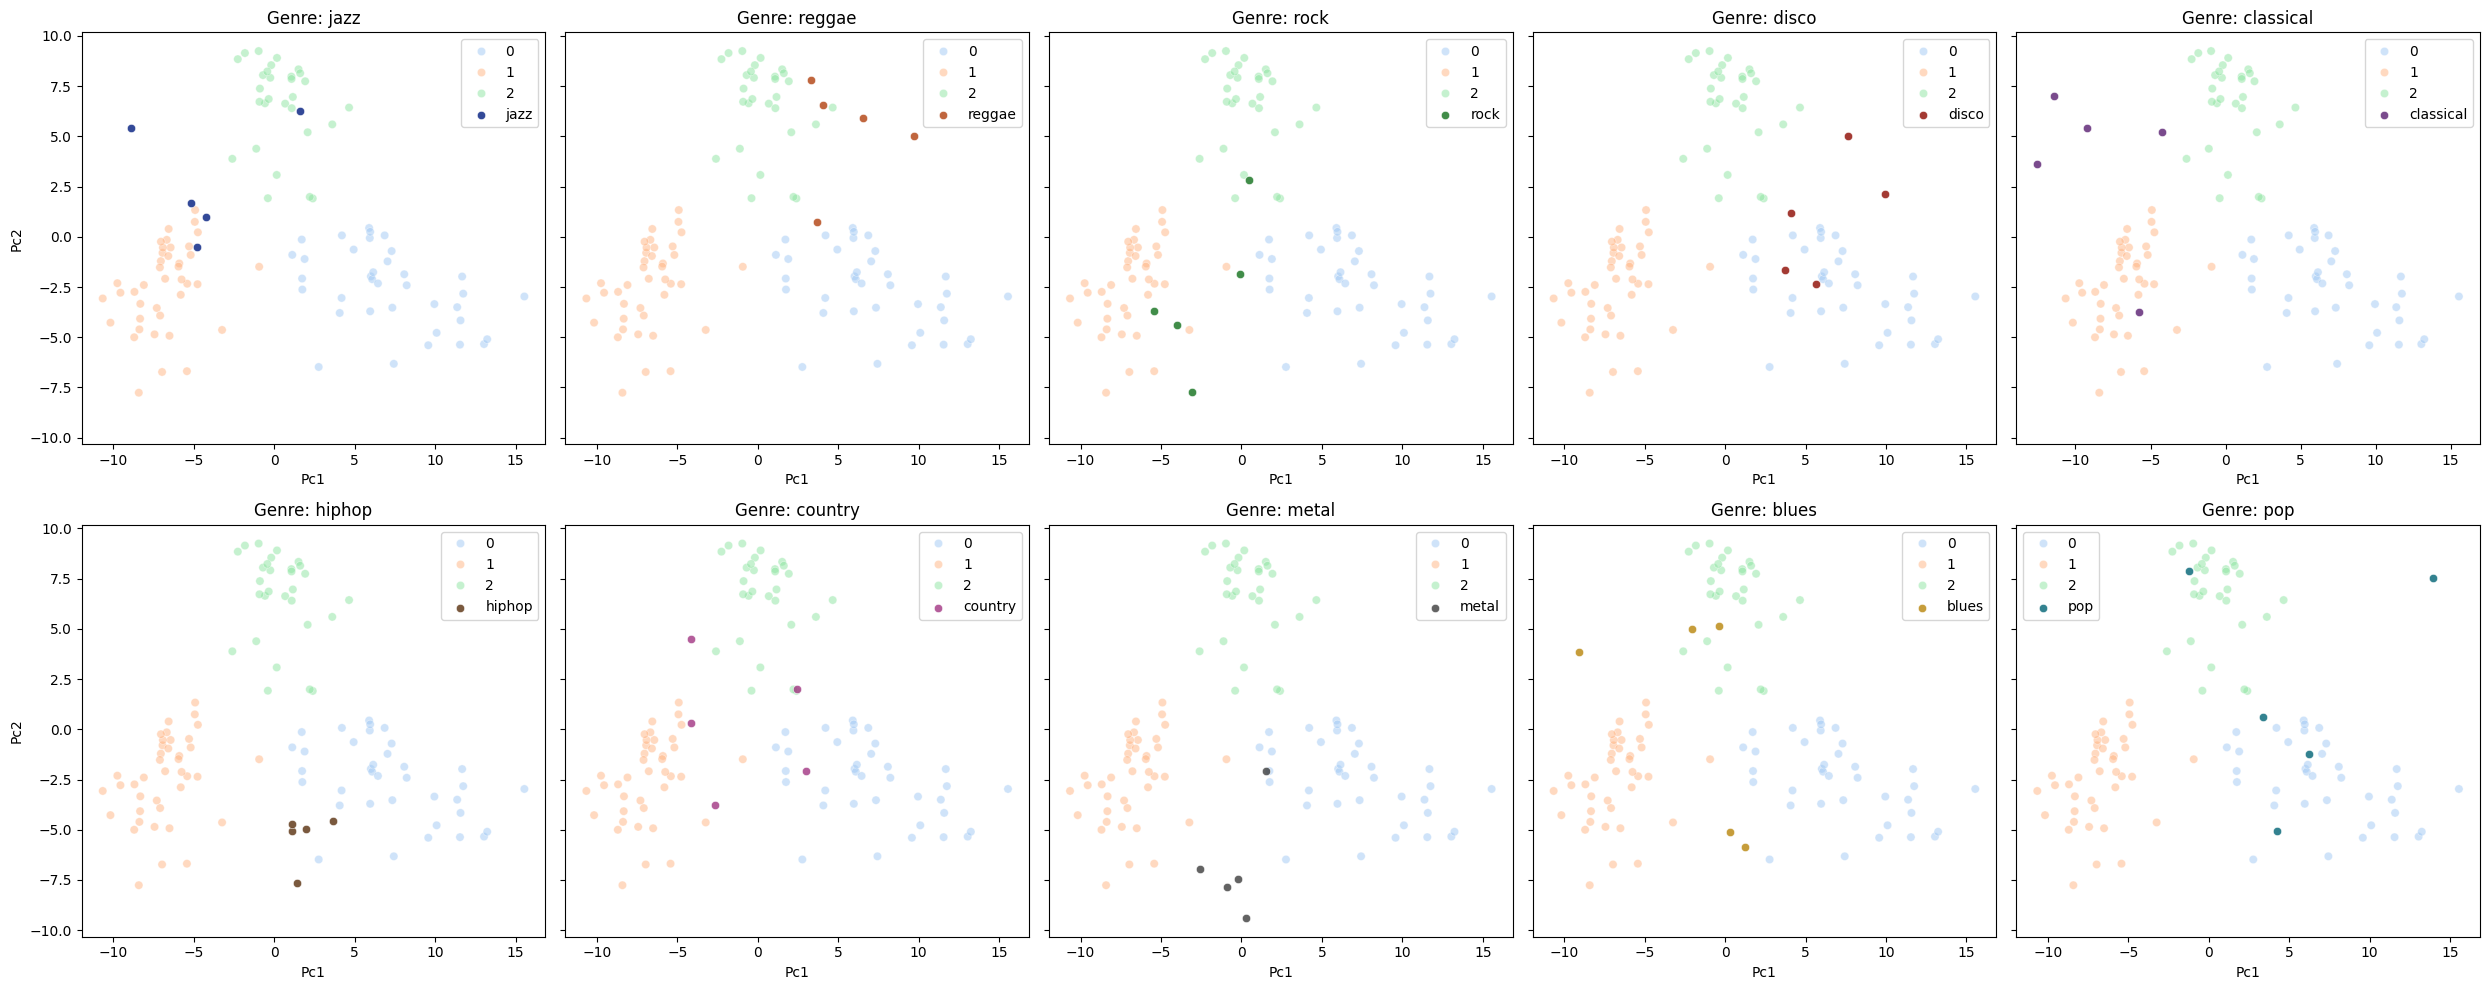

In [ ]:
plot_feature_combinations_pca(
    ('PC1', 'PC2'),
    genres,
    pca_df,
    audio_features_labeled_pca
)


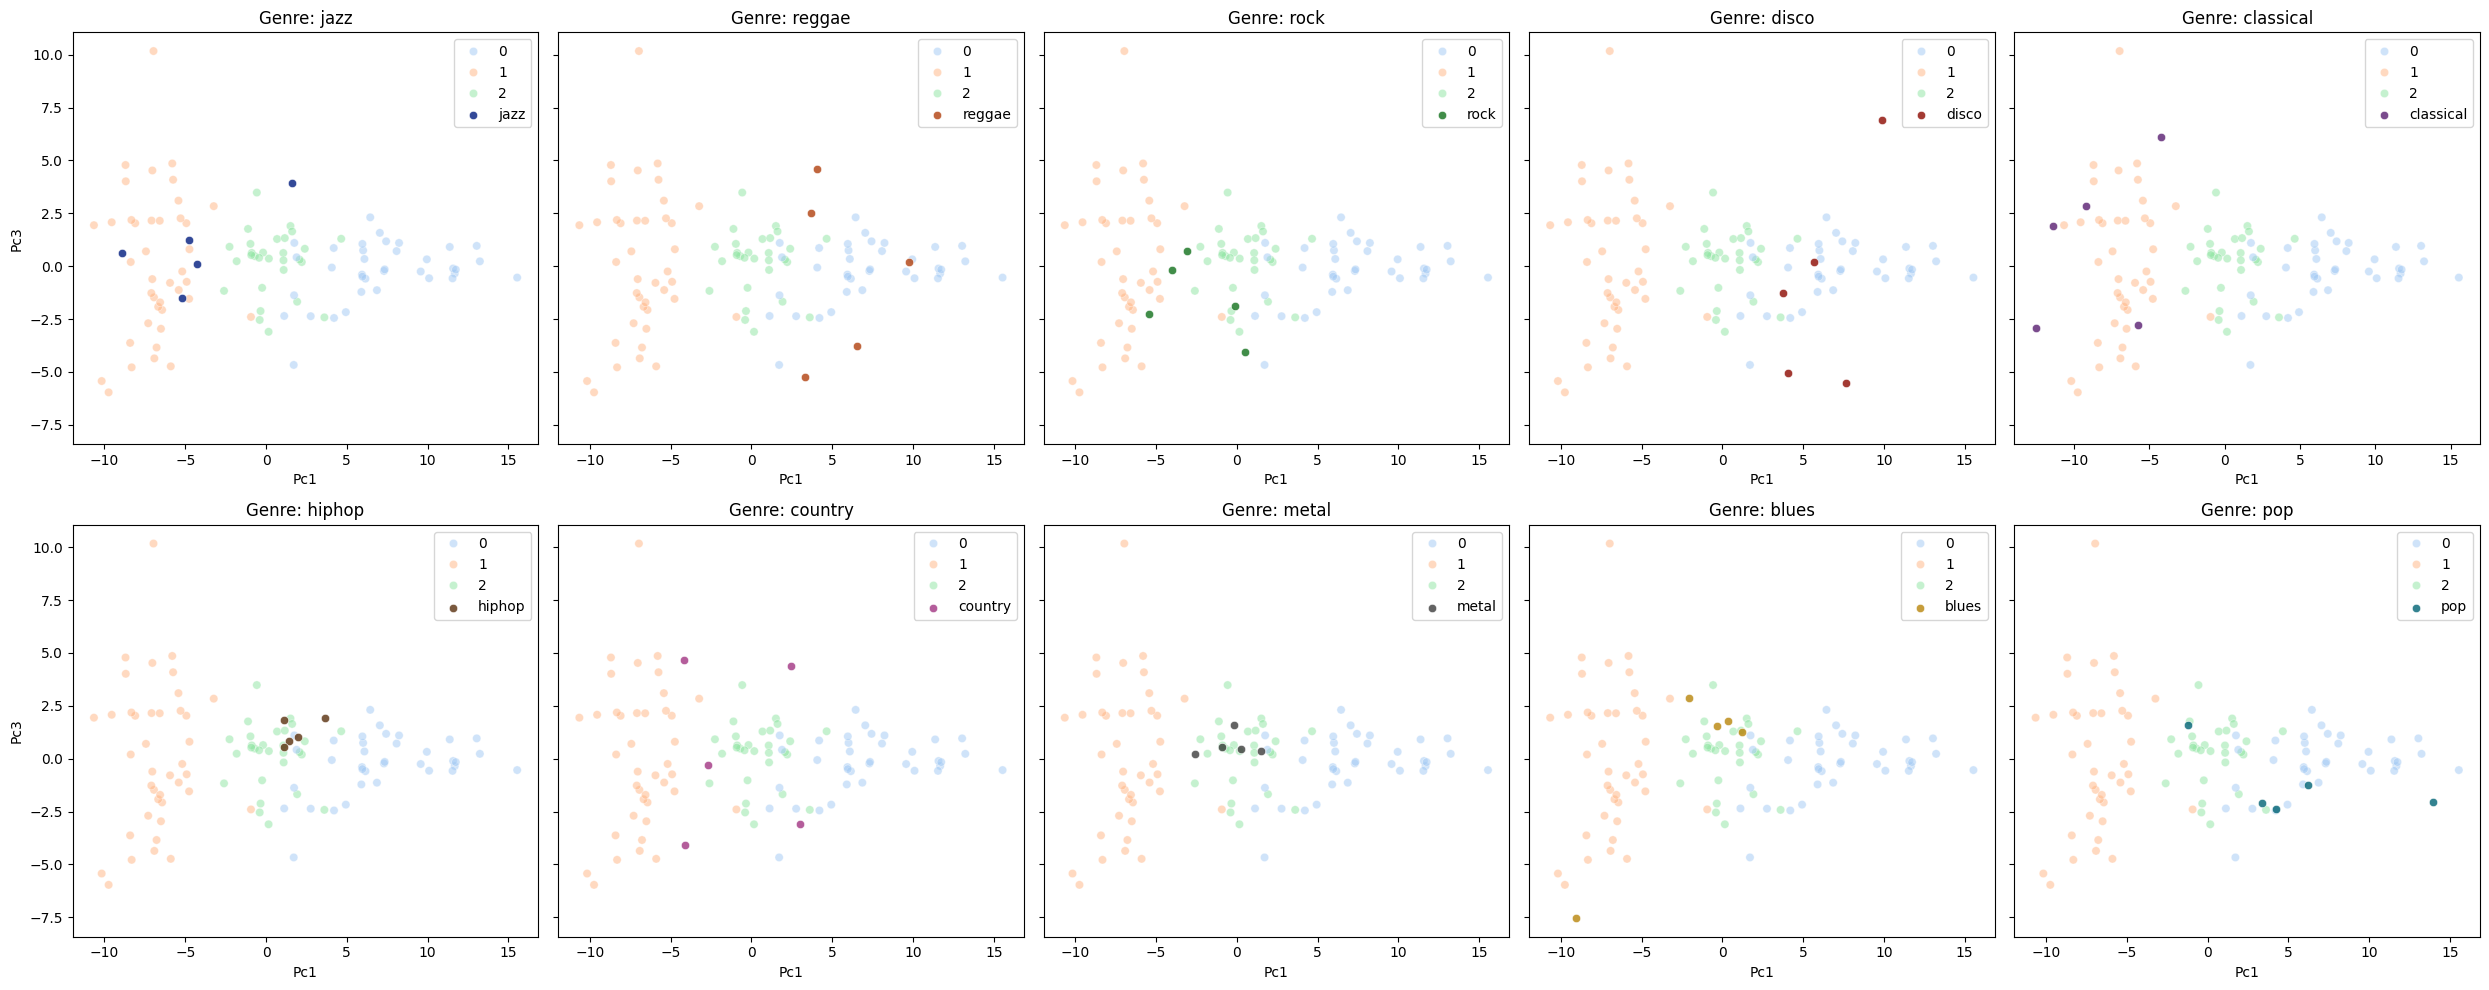

In [ ]:
plot_feature_combinations_pca(
    ('PC1', 'PC3'),
    genres,
    pca_df,
    audio_features_labeled_pca
)


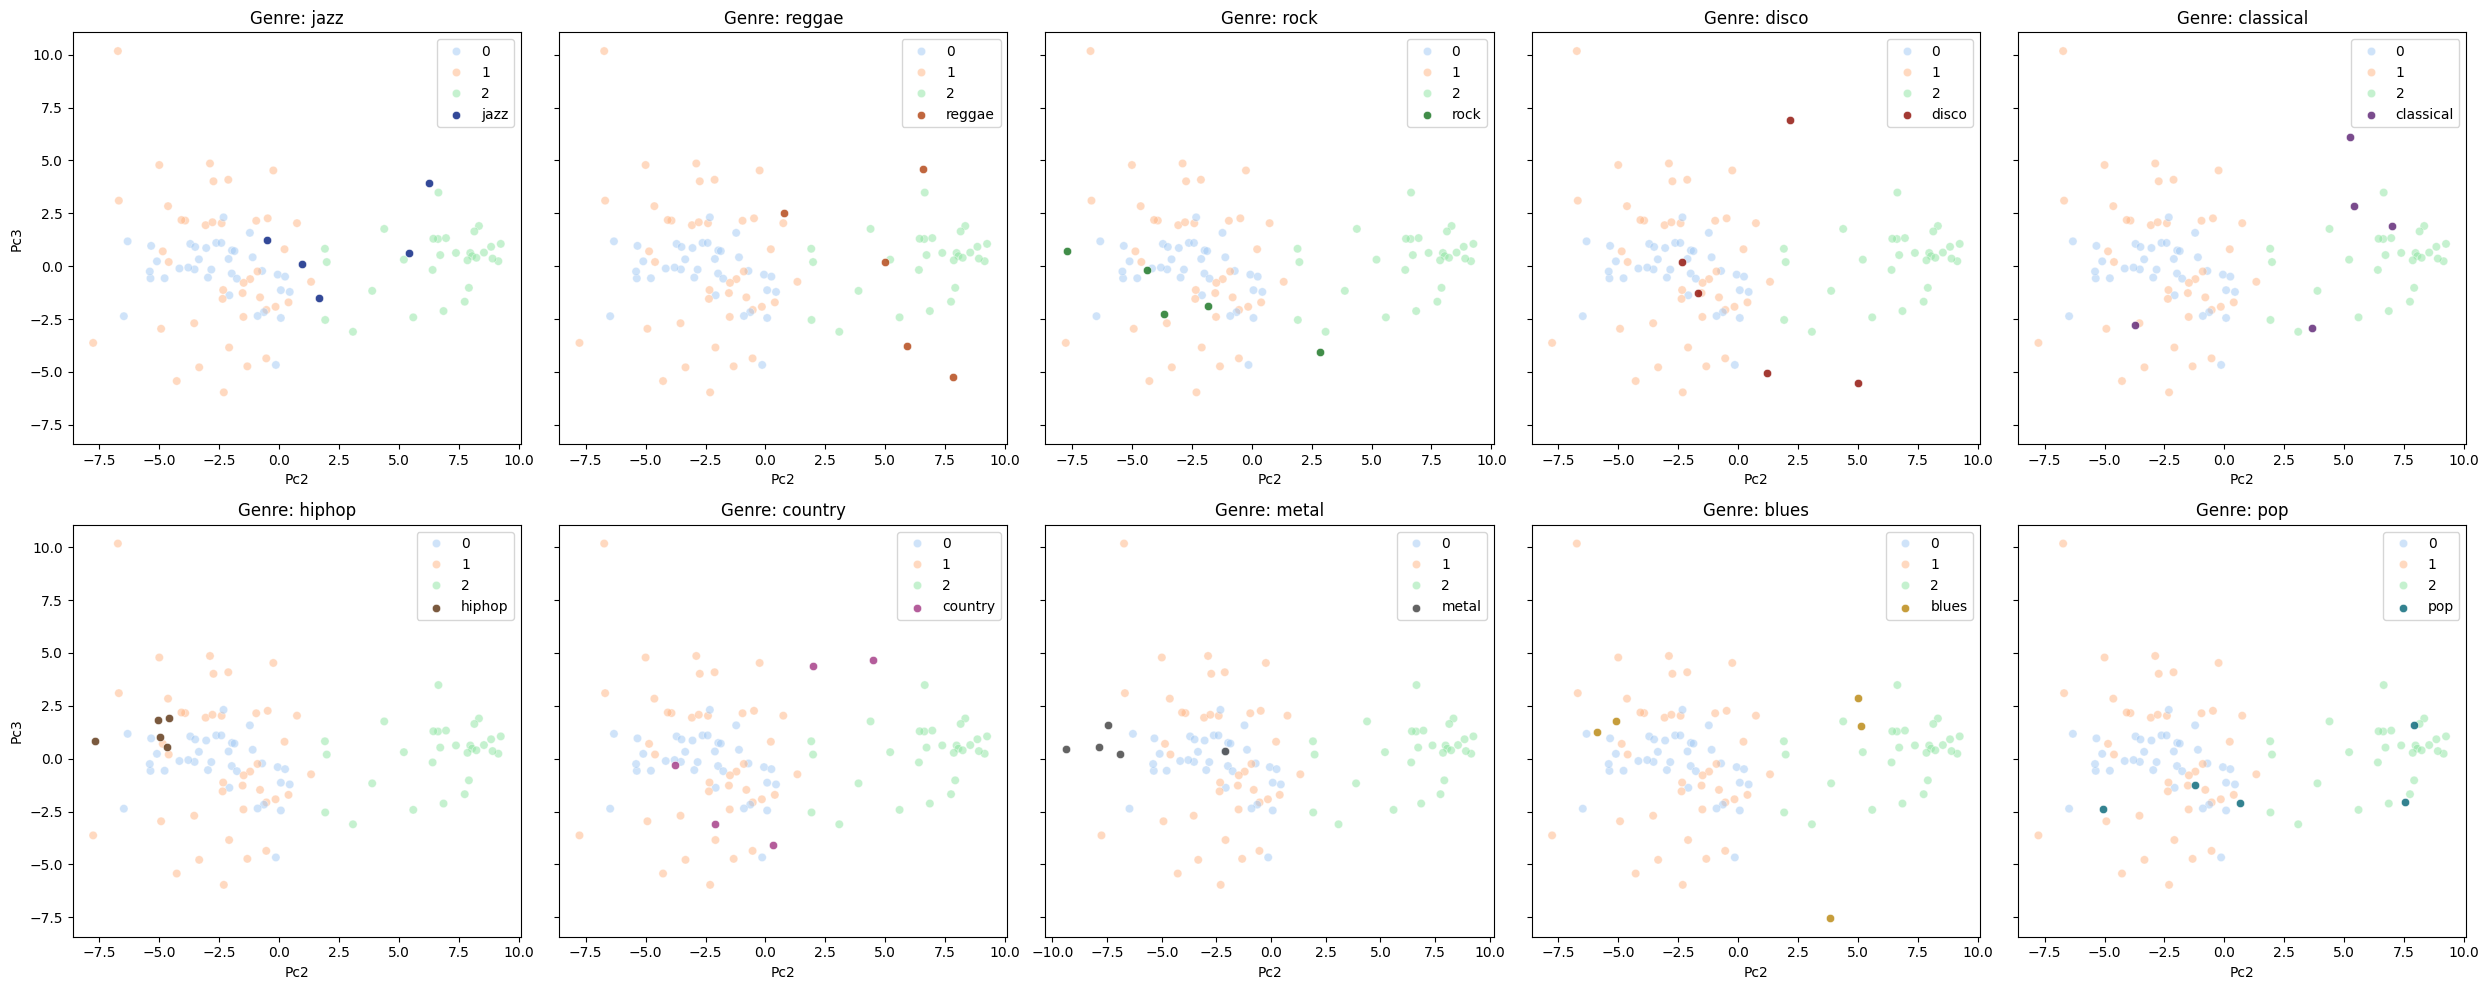

In [ ]:
plot_feature_combinations_pca(
    ('PC2', 'PC3'),
    genres,
    pca_df,
    audio_features_labeled_pca
)


### NMF vs labeled data

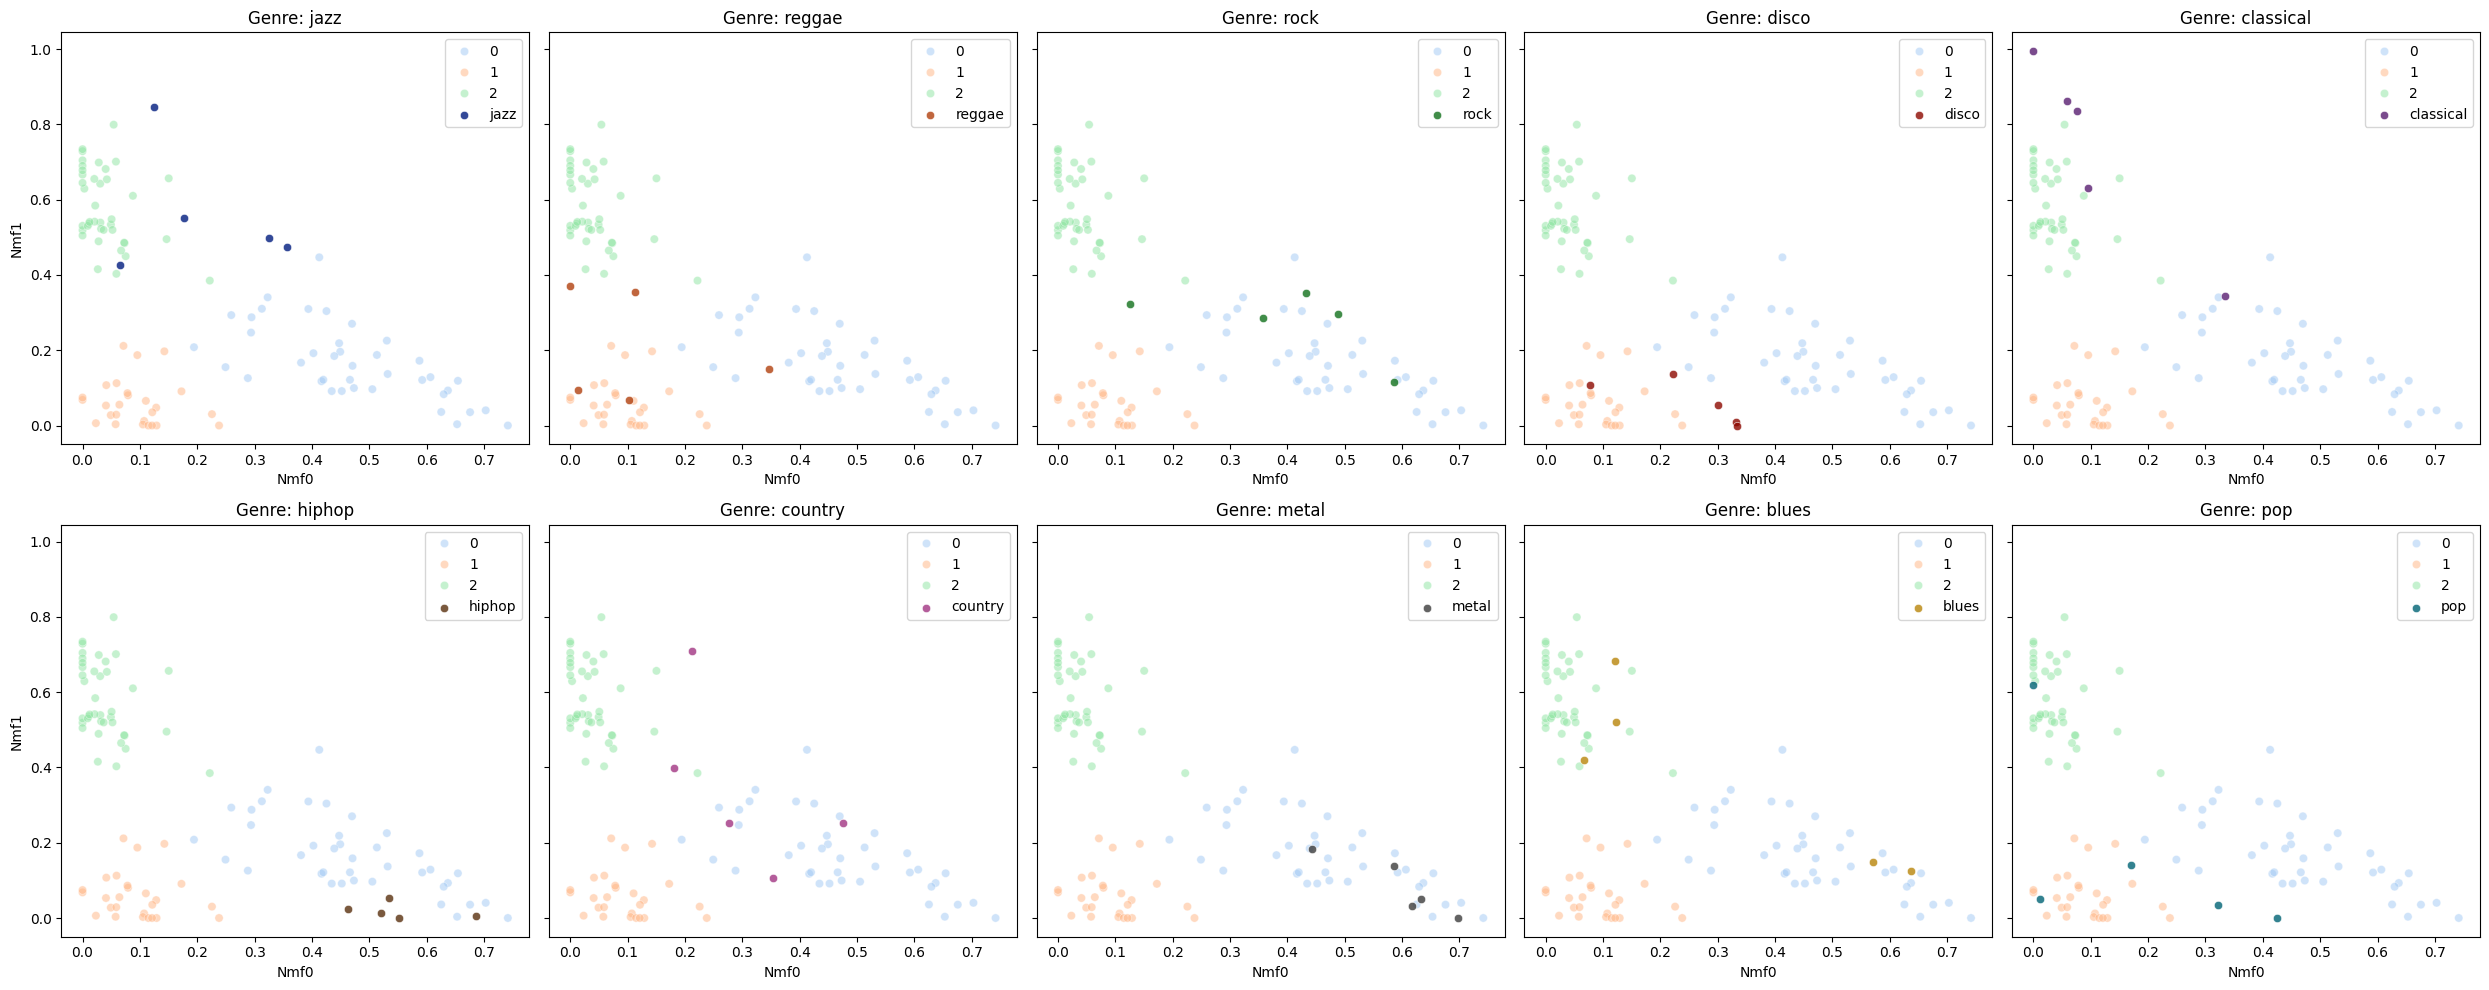

In [ ]:
plot_feature_combinations_nmf(
    ('NMF0', 'NMF1'),
    genres,
    nmf_df,
    audio_features_labeled_nmf
)


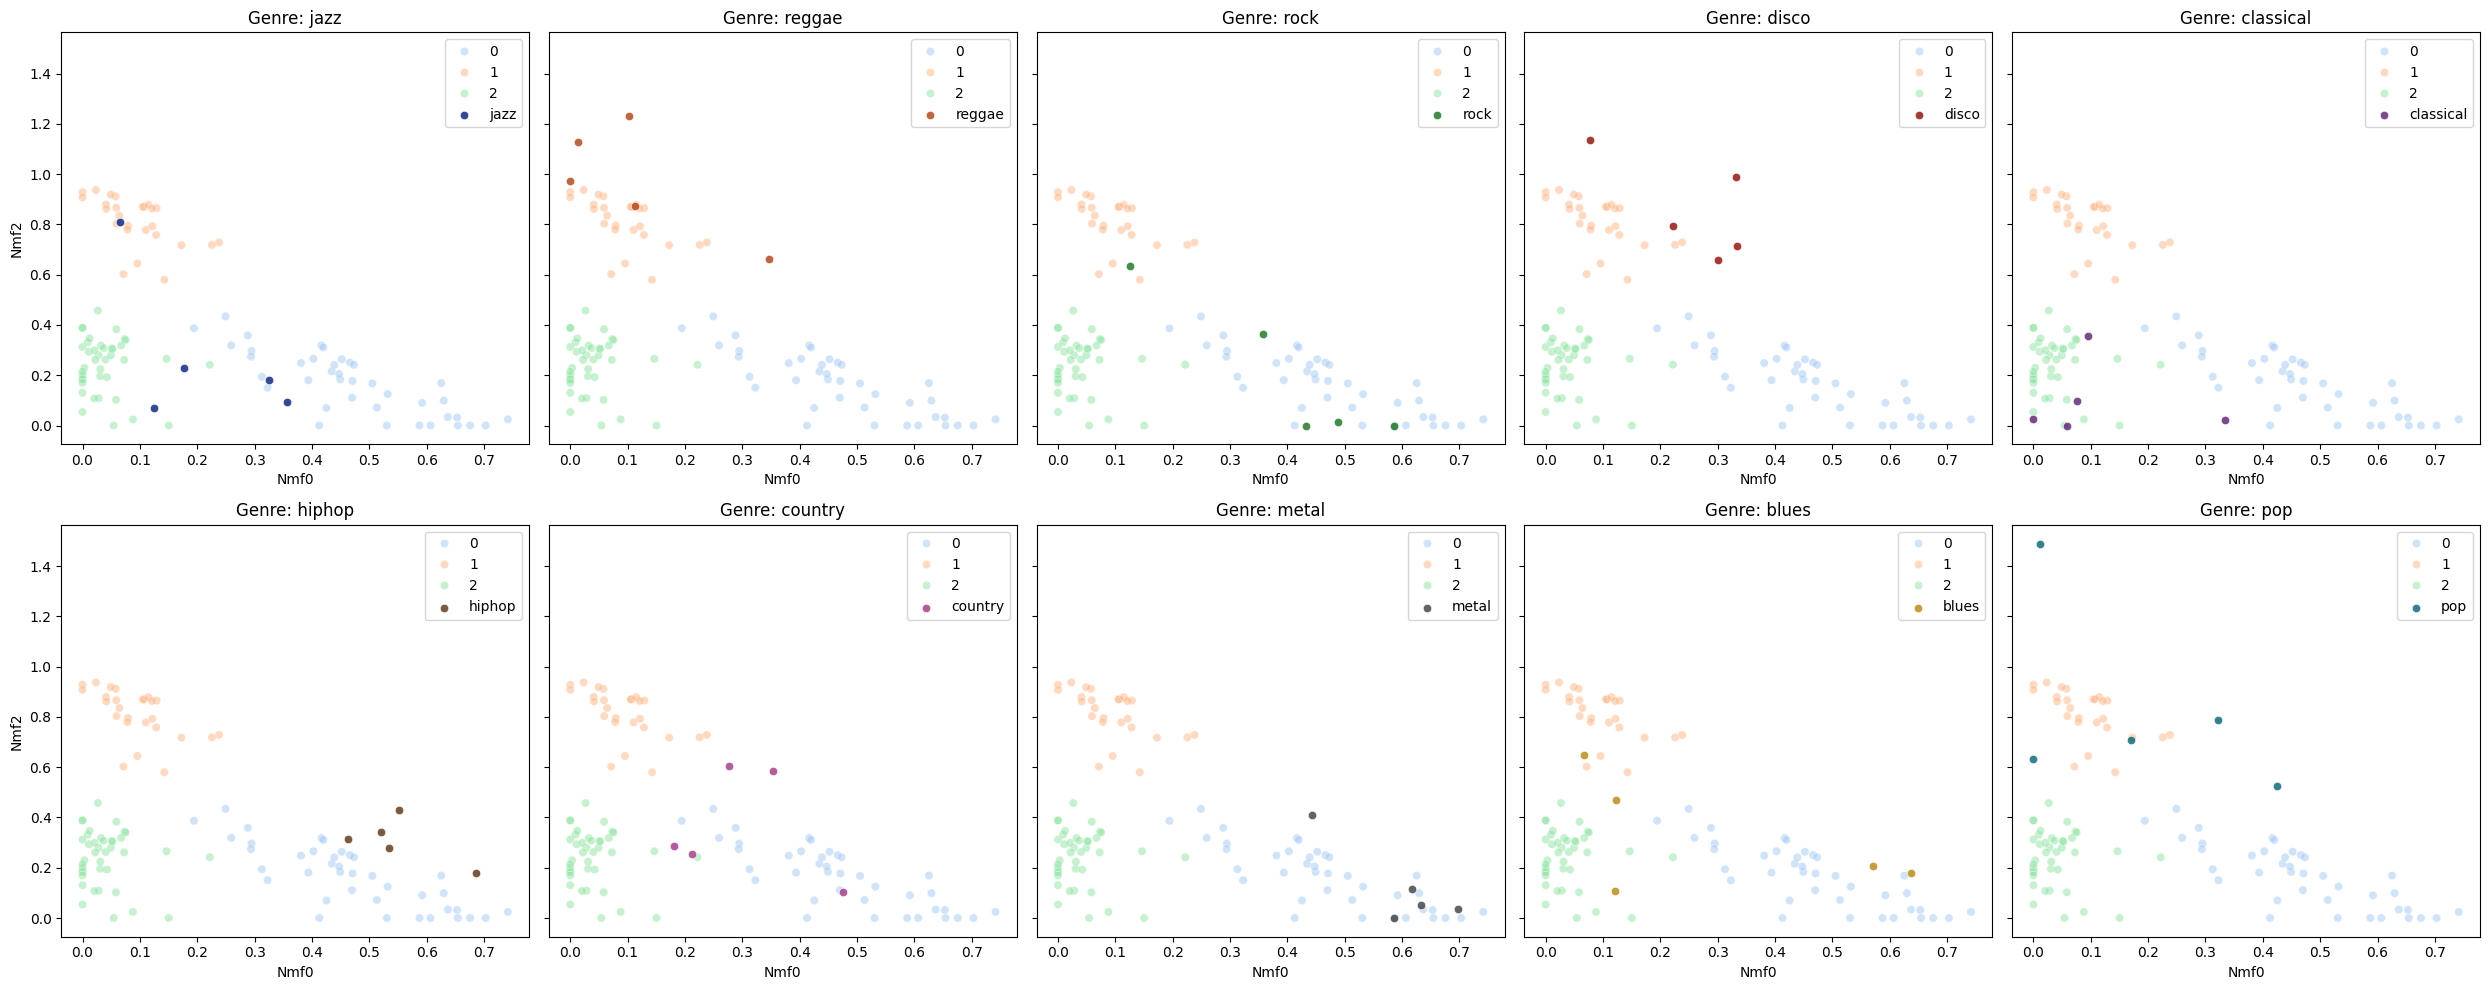

In [ ]:
plot_feature_combinations_nmf(
    ('NMF0', 'NMF2'),
    genres,
    nmf_df,
    audio_features_labeled_nmf
)


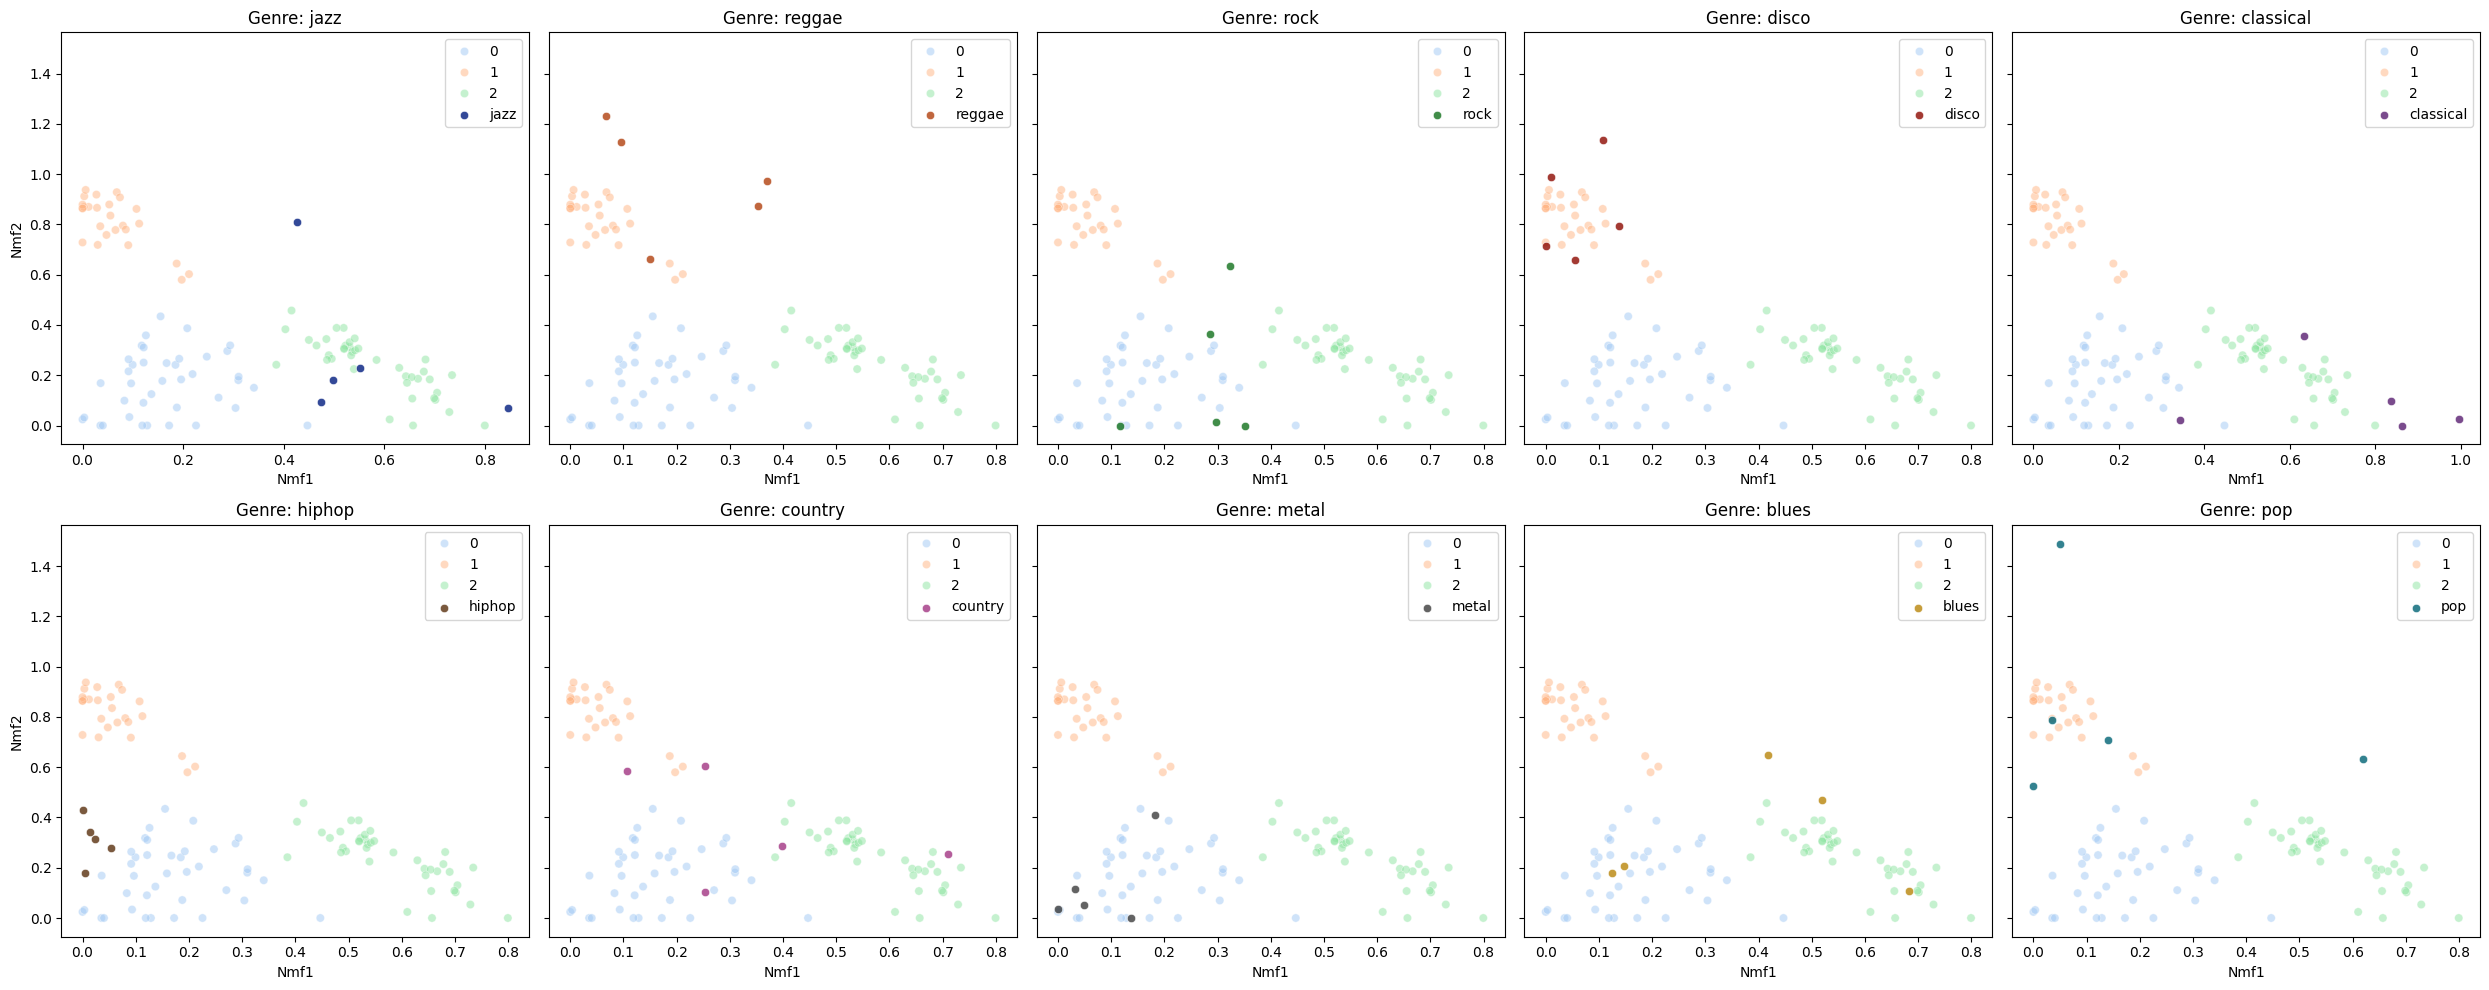

In [ ]:
plot_feature_combinations_nmf(
    ('NMF1', 'NMF2'),
    genres,
    nmf_df,
    audio_features_labeled_nmf
)


**PCA**

Cluster 0 : Pop

Cluster 1: Classical

Cluster 2: Metal


**NMF**

Cluster 0: Metal 

Cluster 1: Pop

Cluster 2: Classical

**Explanation**

After applying PCA and NMF, it is evident that the clusters still correspond to the same genres. The graphs were analyzed and compared in the same way as earlier in the notebook, where K-Means was applied without dimension reduction. The only difference lies in the cluster numbers and associated genres, likely due to the clusters being computed differently during the application of K-Means with dimension reduction.


### Kaggle Scores PCA

In [ ]:
list_unlabeled_filenames = os.listdir('unlabeled')

# Concat the file names of each cluster to the respective cluster

pca_df = pd.concat([pca_df, pd.DataFrame(list_unlabeled_filenames, columns=['file_name'])], axis=1)
nmf_df = pd.concat([nmf_df, pd.DataFrame(list_unlabeled_filenames, columns=['file_name'])], axis=1)



In [ ]:
display(pca_df.head())
display(nmf_df.head())

,PC1,PC2,PC3,cluster,file_name
0,0.682419,6.630192,1.284663,2,m00003.wav
1,1.068867,7.976751,0.623577,2,m00012.wav
2,-4.931586,0.745766,2.033457,1,m00013.wav
3,1.091750,6.405317,-0.178612,2,m00043.wav
4,-6.504448,-4.924103,-2.962237,1,m00044.wav


,NMF0,NMF1,NMF2,cluster,file_name
0,0.110388,0.065456,0.777652,1,m00003.wav
1,0.107340,0.012059,0.869604,1,m00012.wav
2,0.026681,0.415346,0.457281,2,m00013.wav
3,0.128388,0.047545,0.757936,1,m00043.wav
4,0.087818,0.610413,0.024187,2,m00044.wav


For us to submit the file to Kaggle the file_name must be at the front of the dataframe.

In [ ]:
def reorder_columns(df, column_name):
    """
    Reorders the columns of the DataFrame to place the specified column at the first position.

    Parameters:
    df (pd.DataFrame): The DataFrame whose columns need to be reordered.
    column_name (str): The name of the column to be moved to the first position.

    Returns:
    pd.DataFrame: The DataFrame with reordered columns.
    """
    cols = df.columns.tolist()
    cols = [column_name] + [col for col in cols if col != column_name]
    return df[cols]


pca_df = reorder_columns(pca_df, 'file_name')
nmf_df = reorder_columns(nmf_df, 'file_name')


In [ ]:
display(pca_df.head())
display(nmf_df.head())

,file_name,PC1,PC2,PC3,cluster
0,m00003.wav,0.682419,6.630192,1.284663,2
1,m00012.wav,1.068867,7.976751,0.623577,2
2,m00013.wav,-4.931586,0.745766,2.033457,1
3,m00043.wav,1.091750,6.405317,-0.178612,2
4,m00044.wav,-6.504448,-4.924103,-2.962237,1


,file_name,NMF0,NMF1,NMF2,cluster
0,m00003.wav,0.110388,0.065456,0.777652,1
1,m00012.wav,0.107340,0.012059,0.869604,1
2,m00013.wav,0.026681,0.415346,0.457281,2
3,m00043.wav,0.128388,0.047545,0.757936,1
4,m00044.wav,0.087818,0.610413,0.024187,2


In [ ]:
pca_kaggle = pca_df.copy()
nmf_kaggle = nmf_df.copy()

Now we will change the cluster numbers to their genres and create a csv file to submit in the Kaggle competiton.

In [ ]:
def map_clusters_to_genres_pca_nmf(df, cluster_genre_map):
    """
    Maps cluster labels to genre names in the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing the cluster labels.
    cluster_genre_map (dict): Dictionary mapping cluster labels to genre names.

    Returns:
    pd.DataFrame: DataFrame with updated genre names.
    """
    
    # Changing the cluster labels to the genre names
    df['cluster'] = df['cluster'].map(cluster_genre_map)

    # Changing the file_name column to filename
    df.rename(columns={'file_name': 'filename'}, inplace=True)

    # Changing the cluster column to genre
    df.rename(columns={'cluster': 'genre'}, inplace=True)
    df = df[['filename', 'genre']]

    return df

In [ ]:
cluster_genre_map_pca = {0: 'pop', 1: 'classical', 2: 'metal'}
pca_kaggle = map_clusters_to_genres_pca_nmf(pca_kaggle, cluster_genre_map_pca)

In [ ]:
cluster_genre_map_pca = {0: 'pop', 1: 'metal', 2: 'classical'}
nmf_kaggle = map_clusters_to_genres_pca_nmf(nmf_kaggle, cluster_genre_map_pca)

In [ ]:
pca_kaggle.to_csv('pca_kaggle.csv', index=False)


In [ ]:
nmf_kaggle.to_csv('nmf_kaggle.csv', index=False)


## Suggestion app


De recommendation app staat in de recommendation_app.py file, hier worden de datasets geladen en een webinterface gemaakt met streamlit, jammer genoeg werkt het niet perfect.

Het werkt door het bestand te runnen met streamlit in cmd

## Conclusion

### Feature importance


The determination of key components in PCA and NMF is based on the analysis of elbow plots, which are used to decide how many components or features to include.

### Effect dimensionality reduction

**The General Effect of Dimensionality Reduction:**

Dimensionality reduction involves reducing the number of features (columns) in your dataset while retaining as much of the essential information as possible. This process makes the data easier to work with, speeds up computations, and reduces the impact of irrelevant or redundant details (noise). Additionally, it helps prevent overfitting in machine learning models and makes the data more interpretable, especially for visualization purposes in lower dimensions.

**Effect on Our Predictions:**

After applying Principal Component Analysis (PCA), we observed no changes in the clustering results or the Kaggle score. The clustering remained identical to the outcome obtained using KMeans with the original features, and the Kaggle score remained at 0.96226.

When we applied Non-Negative Matrix Factorization (NMF), the clusters changed slightly. These changes led to an improvement in the Kaggle score, which increased to 0.98113.

This demonstrates that while PCA did not provide a significant advantage for this specific dataset, NMF introduced meaningful changes to the clusters that improved prediction performance.

### What additional data would improve the accuracy of predictions?

There are several potential features that could improve the accuracy of the clusters. For instance:

Adding a column indicating whether a track includes vocals or is instrumental. Certain genres are characterized by the absence of vocals, making this feature a valuable criterion for distinguishing between them. Including this type of data could provide more nuanced insights, helping to better separate genres that might otherwise overlap in other dimensions, such as tempo or instrumentation.

A breakdown of dominant instruments in a track (e.g., guitar, synthesizer, piano) could also provide valuable data for distinguishing genres, as instrumentation often defines a genre’s identity.

Track length. Longer tracks may correlate with specific genres like progressive rock, classical, or live recordings, while shorter tracks are often characteristic of pop or punk. This would also help distinguishing genres from eachother. 
